In [1]:
import torch
from torch.utils.data import Dataset, DataLoader, Subset
import torch.nn as nn
import torch.nn.functional as F

from PIL import Image
import torchvision
from torchvision.transforms import v2
from torchvision.models import resnet50, resnet18, ResNet50_Weights, ResNet18_Weights

from torchsummary import summary

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from tempfile import TemporaryDirectory
import time
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tqdm import tqdm
from collections import defaultdict

PATH = "data"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Загрузка и нормализация данных

In [2]:
data_transforms = {
    'train': v2.Compose([
        v2.RandomCrop(32, padding=4),
        v2.RandomHorizontalFlip(),
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
    ]),
    'val': v2.Compose([
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
    ]),
    'test': v2.Compose([
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
    ]),
}

phases = ['train', 'val', 'test']
datasets = {x: torchvision.datasets.CIFAR10(root=PATH, train=x != 'test', download=True, transform=data_transforms[x]) for x in phases}

indices = list(range(len(datasets['train'])))
train_idx, val_idx = train_test_split(indices, random_state=42)

datasets['train'] = Subset(datasets['train'], train_idx)
datasets['val'] = Subset(datasets['val'], val_idx)

batch_size = 32

dataloaders = {x: DataLoader(datasets[x], batch_size=batch_size, shuffle=True if x != "test" else False, num_workers=4, pin_memory=True, persistent_workers=True) for x in phases}
dataset_sizes = {x: len(datasets[x]) for x in phases}

classes = {x: y for x, y in zip(range(10), ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'))} 

In [3]:
dataset_sizes

{'train': 37500, 'val': 12500, 'test': 10000}

In [3]:
classes

{0: 'plane',
 1: 'car',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

Давайте ради интереса покажем несколько изображений в тренировочных данных.

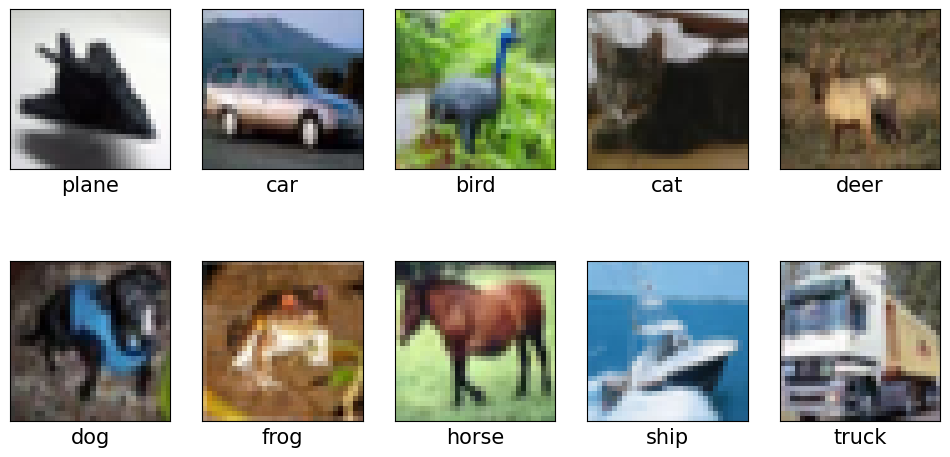

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# visualize training image for each class
sample_images = [datasets['train'].dataset.data[np.asarray(datasets['train'].dataset.targets) == label][0] for label in range(10)]
# show images
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
i = 0
for row in axes:
  for axis in row:
    axis.set_xticks([])
    axis.set_yticks([])
    axis.set_xlabel(classes[i], fontsize=15)
    axis.imshow(sample_images[i])
    i += 1

## Определим сверточную нейронную сеть

In [59]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(32, 32, kernel_size=3, padding=1)

        self.fc1 = nn.Linear(32 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 32)
        self.fc3 = nn.Linear(32, 10)

        self.relu = nn.ReLU()
        
        self.bn_conv1 = nn.BatchNorm2d(16)
        self.bn_conv2 = nn.BatchNorm2d(16)
        self.bn_conv3 = nn.BatchNorm2d(32)
        self.bn_conv4 = nn.BatchNorm2d(32)
        self.bn_fc1 = nn.BatchNorm1d(128)
        self.bn_fc2 = nn.BatchNorm1d(32)

        self.pool = nn.MaxPool2d(2, 2)

        self.dropout_conv = nn.Dropout2d(0.25)
        self.dropout = nn.Dropout(0.5)

        self.flatten = nn.Flatten()

    def forward(self, x):
        out = self.relu(self.bn_conv1(self.conv1(x)))
        out = self.relu(self.bn_conv2(self.conv2(out)))
        out = self.pool(out)
        out = self.dropout_conv(out)

        out = self.relu(self.bn_conv3(self.conv3(out)))
        out = self.relu(self.bn_conv4(self.conv4(out)))
        out = self.pool(out)
        out = self.dropout_conv(out)

        out = self.flatten(out)  # flatten all dimensions except batch

        out = self.relu(self.bn_fc1(self.fc1(out)))
        out = self.dropout(out)

        out = self.relu(self.bn_fc2(self.fc2(out)))
        out = self.dropout(out)

        out = self.fc3(out)
        return out


net = Net().to(device)

In [82]:
summary(net, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
       BatchNorm2d-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
            Conv2d-4           [-1, 16, 32, 32]           2,320
       BatchNorm2d-5           [-1, 16, 32, 32]              32
              ReLU-6           [-1, 16, 32, 32]               0
         MaxPool2d-7           [-1, 16, 16, 16]               0
         Dropout2d-8           [-1, 16, 16, 16]               0
            Conv2d-9           [-1, 32, 16, 16]           4,640
      BatchNorm2d-10           [-1, 32, 16, 16]              64
             ReLU-11           [-1, 32, 16, 16]               0
           Conv2d-12           [-1, 32, 16, 16]           9,248
      BatchNorm2d-13           [-1, 32, 16, 16]              64
             ReLU-14           [-1, 32,

## Определим функцию потерь и алгоритм оптимизации

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, min_lr=0)

## Обучим нейронную сеть

In [ ]:
class MetricMonitor:
    def __init__(self, float_precision=3):
        self.float_precision = float_precision
        self.reset()

    def reset(self):
        self.metrics = defaultdict(lambda: {"val": 0, "count": 0, "avg": 0})

    def update(self, metric_name, val, count):
        metric = self.metrics[metric_name]

        metric["val"] += val
        metric["count"] += count
        metric["avg"] = metric["val"] / metric["count"]

    def __str__(self):
        return " | ".join(
            [
                "{metric_name}: {avg:.{float_precision}f}".format(
                    metric_name=metric_name.capitalize(),
                    avg=metric["avg"],
                    float_precision=self.float_precision,
                )
                for (metric_name, metric) in self.metrics.items()
            ]
        )


def train_model(model, dataloaders, criterion, optimizer, scheduler=None, num_epochs=25):
    since = time.time()
    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')
        torch.save(model.state_dict(), best_model_params_path)

        best_acc = 0.0
        history = {phase: pd.DataFrame(columns=['loss', 'accuracy']) for phase in ['train', 'val']}

        for epoch in range(num_epochs):
            print(f'Epoch {epoch + 1}/{num_epochs}')
            print('-' * 90)
            metric_monitor = MetricMonitor()
            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                # Iterate over data
                stream = tqdm(dataloaders[phase])
                for inputs, labels in stream:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # Zero the parameter gradients
                    optimizer.zero_grad()

                    # Forward
                    # Track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # Backward + step only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # Update metrics
                    metric_monitor.update("loss", loss.item() * inputs.shape[0], inputs.shape[0])
                    metric_monitor.update("accuracy", torch.sum(preds == labels.data).item(), preds.nelement())

                    stream.set_description(f"{phase.capitalize()}.{"  " if phase == 'val' else ''} {metric_monitor}")

                history[phase].loc[epoch] = {f'{name}_{phase}': metric['avg'] for name, metric in metric_monitor.metrics.items()}

            if scheduler is not None:
                scheduler.step(history['val'].loc[epoch]['loss'])

            if history['val'].loc[epoch]['accuracy'] > best_acc:
                best_acc = history['val'].loc[epoch]['accuracy']
                torch.save(model.state_dict(), best_model_params_path)
            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Accuracy: {best_acc:4f}')

        # Load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return pd.concat([data for data in history], axis=1)

In [ ]:
history_net = train_model(net, dataloaders, criterion, optimizer, scheduler, num_epochs=120)

Epoch 1/120
------------------------------------------------------------------------------------------


Train. Loss: 1.991 | Accuracy: 0.240: 100%|██████████| 1172/1172 [00:20<00:00, 56.96it/s] 
Val.   Loss: 1.920 | Accuracy: 0.272: 100%|██████████| 391/391 [00:13<00:00, 29.32it/s] 



Epoch 2/120
------------------------------------------------------------------------------------------


Train. Loss: 1.837 | Accuracy: 0.309: 100%|██████████| 1172/1172 [00:08<00:00, 145.66it/s]
Val.   Loss: 1.771 | Accuracy: 0.337: 100%|██████████| 391/391 [00:01<00:00, 267.90it/s]



Epoch 3/120
------------------------------------------------------------------------------------------


Train. Loss: 1.766 | Accuracy: 0.337: 100%|██████████| 1172/1172 [00:07<00:00, 149.22it/s]
Val.   Loss: 1.687 | Accuracy: 0.369: 100%|██████████| 391/391 [00:01<00:00, 258.30it/s]



Epoch 4/120
------------------------------------------------------------------------------------------


Train. Loss: 1.716 | Accuracy: 0.360: 100%|██████████| 1172/1172 [00:07<00:00, 146.74it/s]
Val.   Loss: 1.655 | Accuracy: 0.382: 100%|██████████| 391/391 [00:01<00:00, 257.57it/s]



Epoch 5/120
------------------------------------------------------------------------------------------


Train. Loss: 1.690 | Accuracy: 0.378: 100%|██████████| 1172/1172 [00:08<00:00, 143.81it/s]
Val.   Loss: 1.610 | Accuracy: 0.408: 100%|██████████| 391/391 [00:01<00:00, 253.59it/s]



Epoch 6/120
------------------------------------------------------------------------------------------


Train. Loss: 1.652 | Accuracy: 0.392: 100%|██████████| 1172/1172 [00:08<00:00, 146.31it/s]
Val.   Loss: 1.569 | Accuracy: 0.424: 100%|██████████| 391/391 [00:01<00:00, 256.52it/s]



Epoch 7/120
------------------------------------------------------------------------------------------


Train. Loss: 1.625 | Accuracy: 0.403: 100%|██████████| 1172/1172 [00:07<00:00, 146.55it/s]
Val.   Loss: 1.538 | Accuracy: 0.435: 100%|██████████| 391/391 [00:01<00:00, 267.75it/s]



Epoch 8/120
------------------------------------------------------------------------------------------


Train. Loss: 1.607 | Accuracy: 0.415: 100%|██████████| 1172/1172 [00:08<00:00, 141.91it/s]
Val.   Loss: 1.516 | Accuracy: 0.447: 100%|██████████| 391/391 [00:01<00:00, 263.73it/s]



Epoch 9/120
------------------------------------------------------------------------------------------


Train. Loss: 1.586 | Accuracy: 0.422: 100%|██████████| 1172/1172 [00:07<00:00, 151.72it/s]
Val.   Loss: 1.491 | Accuracy: 0.456: 100%|██████████| 391/391 [00:01<00:00, 241.53it/s]



Epoch 10/120
------------------------------------------------------------------------------------------


Train. Loss: 1.568 | Accuracy: 0.431: 100%|██████████| 1172/1172 [00:08<00:00, 146.05it/s]
Val.   Loss: 1.477 | Accuracy: 0.467: 100%|██████████| 391/391 [00:01<00:00, 265.55it/s]



Epoch 11/120
------------------------------------------------------------------------------------------


Train. Loss: 1.543 | Accuracy: 0.439: 100%|██████████| 1172/1172 [00:07<00:00, 150.10it/s]
Val.   Loss: 1.452 | Accuracy: 0.476: 100%|██████████| 391/391 [00:01<00:00, 283.40it/s]



Epoch 12/120
------------------------------------------------------------------------------------------


Train. Loss: 1.534 | Accuracy: 0.448: 100%|██████████| 1172/1172 [00:07<00:00, 152.00it/s]
Val.   Loss: 1.447 | Accuracy: 0.478: 100%|██████████| 391/391 [00:01<00:00, 282.89it/s]



Epoch 13/120
------------------------------------------------------------------------------------------


Train. Loss: 1.472 | Accuracy: 0.468: 100%|██████████| 1172/1172 [00:07<00:00, 149.51it/s]
Val.   Loss: 1.380 | Accuracy: 0.501: 100%|██████████| 391/391 [00:01<00:00, 294.78it/s]



Epoch 14/120
------------------------------------------------------------------------------------------


Train. Loss: 1.446 | Accuracy: 0.480: 100%|██████████| 1172/1172 [00:07<00:00, 149.96it/s]
Val.   Loss: 1.360 | Accuracy: 0.512: 100%|██████████| 391/391 [00:01<00:00, 287.07it/s]



Epoch 15/120
------------------------------------------------------------------------------------------


Train. Loss: 1.435 | Accuracy: 0.483: 100%|██████████| 1172/1172 [00:07<00:00, 149.44it/s]
Val.   Loss: 1.348 | Accuracy: 0.513: 100%|██████████| 391/391 [00:01<00:00, 298.54it/s]



Epoch 16/120
------------------------------------------------------------------------------------------


Train. Loss: 1.432 | Accuracy: 0.488: 100%|██████████| 1172/1172 [00:08<00:00, 144.24it/s]
Val.   Loss: 1.345 | Accuracy: 0.519: 100%|██████████| 391/391 [00:01<00:00, 267.52it/s]



Epoch 17/120
------------------------------------------------------------------------------------------


Train. Loss: 1.433 | Accuracy: 0.486: 100%|██████████| 1172/1172 [00:08<00:00, 145.30it/s]
Val.   Loss: 1.344 | Accuracy: 0.518: 100%|██████████| 391/391 [00:01<00:00, 271.52it/s]



Epoch 18/120
------------------------------------------------------------------------------------------


Train. Loss: 1.416 | Accuracy: 0.496: 100%|██████████| 1172/1172 [00:07<00:00, 151.94it/s]
Val.   Loss: 1.331 | Accuracy: 0.524: 100%|██████████| 391/391 [00:01<00:00, 270.93it/s]



Epoch 19/120
------------------------------------------------------------------------------------------


Train. Loss: 1.417 | Accuracy: 0.492: 100%|██████████| 1172/1172 [00:07<00:00, 152.40it/s]
Val.   Loss: 1.331 | Accuracy: 0.522: 100%|██████████| 391/391 [00:01<00:00, 277.19it/s]



Epoch 20/120
------------------------------------------------------------------------------------------


Train. Loss: 1.414 | Accuracy: 0.491: 100%|██████████| 1172/1172 [00:07<00:00, 147.75it/s]
Val.   Loss: 1.326 | Accuracy: 0.522: 100%|██████████| 391/391 [00:01<00:00, 260.83it/s]



Epoch 21/120
------------------------------------------------------------------------------------------


Train. Loss: 1.407 | Accuracy: 0.495: 100%|██████████| 1172/1172 [00:07<00:00, 149.32it/s]
Val.   Loss: 1.320 | Accuracy: 0.527: 100%|██████████| 391/391 [00:01<00:00, 268.16it/s]



Epoch 22/120
------------------------------------------------------------------------------------------


Train. Loss: 1.409 | Accuracy: 0.499: 100%|██████████| 1172/1172 [00:07<00:00, 153.45it/s]
Val.   Loss: 1.321 | Accuracy: 0.530: 100%|██████████| 391/391 [00:01<00:00, 254.18it/s]



Epoch 23/120
------------------------------------------------------------------------------------------


Train. Loss: 1.402 | Accuracy: 0.500: 100%|██████████| 1172/1172 [00:07<00:00, 149.82it/s]
Val.   Loss: 1.313 | Accuracy: 0.531: 100%|██████████| 391/391 [00:01<00:00, 274.25it/s]



Epoch 24/120
------------------------------------------------------------------------------------------


Train. Loss: 1.401 | Accuracy: 0.504: 100%|██████████| 1172/1172 [00:07<00:00, 150.95it/s]
Val.   Loss: 1.311 | Accuracy: 0.534: 100%|██████████| 391/391 [00:01<00:00, 291.24it/s]



Epoch 25/120
------------------------------------------------------------------------------------------


Train. Loss: 1.403 | Accuracy: 0.501: 100%|██████████| 1172/1172 [00:07<00:00, 150.64it/s]
Val.   Loss: 1.313 | Accuracy: 0.532: 100%|██████████| 391/391 [00:01<00:00, 304.45it/s]



Epoch 26/120
------------------------------------------------------------------------------------------


Train. Loss: 1.395 | Accuracy: 0.501: 100%|██████████| 1172/1172 [00:08<00:00, 142.05it/s]
Val.   Loss: 1.308 | Accuracy: 0.532: 100%|██████████| 391/391 [00:01<00:00, 276.59it/s]



Epoch 27/120
------------------------------------------------------------------------------------------


Train. Loss: 1.395 | Accuracy: 0.507: 100%|██████████| 1172/1172 [00:07<00:00, 147.14it/s]
Val.   Loss: 1.308 | Accuracy: 0.537: 100%|██████████| 391/391 [00:01<00:00, 282.96it/s]



Epoch 28/120
------------------------------------------------------------------------------------------


Train. Loss: 1.392 | Accuracy: 0.503: 100%|██████████| 1172/1172 [00:08<00:00, 145.46it/s]
Val.   Loss: 1.308 | Accuracy: 0.534: 100%|██████████| 391/391 [00:01<00:00, 282.86it/s]



Epoch 29/120
------------------------------------------------------------------------------------------


Train. Loss: 1.397 | Accuracy: 0.504: 100%|██████████| 1172/1172 [00:08<00:00, 145.50it/s]
Val.   Loss: 1.309 | Accuracy: 0.534: 100%|██████████| 391/391 [00:01<00:00, 289.94it/s]



Epoch 30/120
------------------------------------------------------------------------------------------


Train. Loss: 1.388 | Accuracy: 0.507: 100%|██████████| 1172/1172 [00:07<00:00, 149.18it/s]
Val.   Loss: 1.301 | Accuracy: 0.536: 100%|██████████| 391/391 [00:01<00:00, 262.79it/s]



Epoch 31/120
------------------------------------------------------------------------------------------


Train. Loss: 1.399 | Accuracy: 0.503: 100%|██████████| 1172/1172 [00:07<00:00, 147.42it/s]
Val.   Loss: 1.311 | Accuracy: 0.533: 100%|██████████| 391/391 [00:01<00:00, 263.22it/s]



Epoch 32/120
------------------------------------------------------------------------------------------


Train. Loss: 1.393 | Accuracy: 0.506: 100%|██████████| 1172/1172 [00:07<00:00, 150.04it/s]
Val.   Loss: 1.305 | Accuracy: 0.536: 100%|██████████| 391/391 [00:01<00:00, 269.86it/s]



Epoch 33/120
------------------------------------------------------------------------------------------


Train. Loss: 1.390 | Accuracy: 0.505: 100%|██████████| 1172/1172 [00:07<00:00, 147.49it/s]
Val.   Loss: 1.301 | Accuracy: 0.535: 100%|██████████| 391/391 [00:01<00:00, 256.70it/s]



Epoch 34/120
------------------------------------------------------------------------------------------


Train. Loss: 1.397 | Accuracy: 0.504: 100%|██████████| 1172/1172 [00:07<00:00, 151.15it/s]
Val.   Loss: 1.308 | Accuracy: 0.534: 100%|██████████| 391/391 [00:01<00:00, 263.63it/s]



Epoch 35/120
------------------------------------------------------------------------------------------


Train. Loss: 1.393 | Accuracy: 0.502: 100%|██████████| 1172/1172 [00:07<00:00, 151.27it/s]
Val.   Loss: 1.305 | Accuracy: 0.533: 100%|██████████| 391/391 [00:01<00:00, 307.41it/s]



Epoch 36/120
------------------------------------------------------------------------------------------


Train. Loss: 1.390 | Accuracy: 0.506: 100%|██████████| 1172/1172 [00:07<00:00, 150.88it/s]
Val.   Loss: 1.304 | Accuracy: 0.535: 100%|██████████| 391/391 [00:01<00:00, 275.06it/s]



Epoch 37/120
------------------------------------------------------------------------------------------


Train. Loss: 1.398 | Accuracy: 0.504: 100%|██████████| 1172/1172 [00:07<00:00, 151.28it/s]
Val.   Loss: 1.308 | Accuracy: 0.535: 100%|██████████| 391/391 [00:01<00:00, 287.37it/s]



Epoch 38/120
------------------------------------------------------------------------------------------


Train. Loss: 1.394 | Accuracy: 0.505: 100%|██████████| 1172/1172 [00:07<00:00, 162.13it/s]
Val.   Loss: 1.308 | Accuracy: 0.534: 100%|██████████| 391/391 [00:01<00:00, 281.56it/s]



Epoch 39/120
------------------------------------------------------------------------------------------


Train. Loss: 1.385 | Accuracy: 0.504: 100%|██████████| 1172/1172 [00:07<00:00, 164.54it/s]
Val.   Loss: 1.302 | Accuracy: 0.534: 100%|██████████| 391/391 [00:01<00:00, 304.59it/s]



Epoch 40/120
------------------------------------------------------------------------------------------


Train. Loss: 1.397 | Accuracy: 0.503: 100%|██████████| 1172/1172 [00:07<00:00, 165.94it/s]
Val.   Loss: 1.308 | Accuracy: 0.534: 100%|██████████| 391/391 [00:01<00:00, 306.01it/s]



Epoch 41/120
------------------------------------------------------------------------------------------


Train. Loss: 1.387 | Accuracy: 0.504: 100%|██████████| 1172/1172 [00:07<00:00, 166.46it/s]
Val.   Loss: 1.300 | Accuracy: 0.534: 100%|██████████| 391/391 [00:01<00:00, 312.23it/s]



Epoch 42/120
------------------------------------------------------------------------------------------


Train. Loss: 1.390 | Accuracy: 0.505: 100%|██████████| 1172/1172 [00:07<00:00, 164.41it/s]
Val.   Loss: 1.302 | Accuracy: 0.535: 100%|██████████| 391/391 [00:01<00:00, 293.78it/s]



Epoch 43/120
------------------------------------------------------------------------------------------


Train. Loss: 1.393 | Accuracy: 0.505: 100%|██████████| 1172/1172 [00:07<00:00, 162.60it/s]
Val.   Loss: 1.307 | Accuracy: 0.535: 100%|██████████| 391/391 [00:01<00:00, 319.97it/s]



Epoch 44/120
------------------------------------------------------------------------------------------


Train. Loss: 1.392 | Accuracy: 0.503: 100%|██████████| 1172/1172 [00:07<00:00, 163.03it/s]
Val.   Loss: 1.305 | Accuracy: 0.534: 100%|██████████| 391/391 [00:01<00:00, 314.03it/s]



Epoch 45/120
------------------------------------------------------------------------------------------


Train. Loss: 1.387 | Accuracy: 0.506: 100%|██████████| 1172/1172 [00:07<00:00, 164.29it/s]
Val.   Loss: 1.304 | Accuracy: 0.536: 100%|██████████| 391/391 [00:01<00:00, 298.64it/s]



Epoch 46/120
------------------------------------------------------------------------------------------


Train. Loss: 1.386 | Accuracy: 0.507: 100%|██████████| 1172/1172 [00:07<00:00, 161.26it/s]
Val.   Loss: 1.301 | Accuracy: 0.537: 100%|██████████| 391/391 [00:01<00:00, 279.22it/s]



Epoch 47/120
------------------------------------------------------------------------------------------


Train. Loss: 1.393 | Accuracy: 0.505: 100%|██████████| 1172/1172 [00:07<00:00, 165.66it/s]
Val.   Loss: 1.307 | Accuracy: 0.534: 100%|██████████| 391/391 [00:01<00:00, 294.09it/s]



Epoch 48/120
------------------------------------------------------------------------------------------


Train. Loss: 1.390 | Accuracy: 0.504: 100%|██████████| 1172/1172 [00:07<00:00, 163.09it/s]
Val.   Loss: 1.305 | Accuracy: 0.534: 100%|██████████| 391/391 [00:01<00:00, 296.32it/s]



Epoch 49/120
------------------------------------------------------------------------------------------


Train. Loss: 1.392 | Accuracy: 0.507: 100%|██████████| 1172/1172 [00:07<00:00, 162.75it/s]
Val.   Loss: 1.304 | Accuracy: 0.536: 100%|██████████| 391/391 [00:01<00:00, 303.69it/s]



Epoch 50/120
------------------------------------------------------------------------------------------


Train. Loss: 1.392 | Accuracy: 0.499: 100%|██████████| 1172/1172 [00:07<00:00, 164.87it/s]
Val.   Loss: 1.304 | Accuracy: 0.531: 100%|██████████| 391/391 [00:01<00:00, 298.28it/s]



Epoch 51/120
------------------------------------------------------------------------------------------


Train. Loss: 1.387 | Accuracy: 0.505: 100%|██████████| 1172/1172 [00:07<00:00, 164.38it/s]
Val.   Loss: 1.301 | Accuracy: 0.535: 100%|██████████| 391/391 [00:01<00:00, 297.50it/s]



Epoch 52/120
------------------------------------------------------------------------------------------


Train. Loss: 1.392 | Accuracy: 0.504: 100%|██████████| 1172/1172 [00:07<00:00, 165.02it/s]
Val.   Loss: 1.305 | Accuracy: 0.535: 100%|██████████| 391/391 [00:01<00:00, 306.44it/s]



Epoch 53/120
------------------------------------------------------------------------------------------


Train. Loss: 1.392 | Accuracy: 0.501: 100%|██████████| 1172/1172 [00:07<00:00, 161.36it/s]
Val.   Loss: 1.304 | Accuracy: 0.531: 100%|██████████| 391/391 [00:01<00:00, 314.13it/s]



Epoch 54/120
------------------------------------------------------------------------------------------


Train. Loss: 1.390 | Accuracy: 0.505: 100%|██████████| 1172/1172 [00:07<00:00, 159.58it/s]
Val.   Loss: 1.303 | Accuracy: 0.535: 100%|██████████| 391/391 [00:01<00:00, 302.79it/s]



Epoch 55/120
------------------------------------------------------------------------------------------


Train. Loss: 1.394 | Accuracy: 0.505: 100%|██████████| 1172/1172 [00:07<00:00, 165.07it/s]
Val.   Loss: 1.305 | Accuracy: 0.535: 100%|██████████| 391/391 [00:01<00:00, 298.87it/s]



Epoch 56/120
------------------------------------------------------------------------------------------


Train. Loss: 1.387 | Accuracy: 0.506: 100%|██████████| 1172/1172 [00:07<00:00, 161.96it/s]
Val.   Loss: 1.302 | Accuracy: 0.536: 100%|██████████| 391/391 [00:01<00:00, 306.02it/s]



Epoch 57/120
------------------------------------------------------------------------------------------


Train. Loss: 1.392 | Accuracy: 0.502: 100%|██████████| 1172/1172 [00:07<00:00, 163.53it/s]
Val.   Loss: 1.307 | Accuracy: 0.532: 100%|██████████| 391/391 [00:01<00:00, 316.82it/s]



Epoch 58/120
------------------------------------------------------------------------------------------


Train. Loss: 1.388 | Accuracy: 0.507: 100%|██████████| 1172/1172 [00:07<00:00, 164.80it/s]
Val.   Loss: 1.302 | Accuracy: 0.536: 100%|██████████| 391/391 [00:01<00:00, 268.42it/s]



Epoch 59/120
------------------------------------------------------------------------------------------


Train. Loss: 1.392 | Accuracy: 0.504: 100%|██████████| 1172/1172 [00:07<00:00, 149.38it/s]
Val.   Loss: 1.305 | Accuracy: 0.534: 100%|██████████| 391/391 [00:01<00:00, 277.05it/s]



Epoch 60/120
------------------------------------------------------------------------------------------


Train. Loss: 1.394 | Accuracy: 0.503: 100%|██████████| 1172/1172 [00:07<00:00, 147.99it/s]
Val.   Loss: 1.306 | Accuracy: 0.534: 100%|██████████| 391/391 [00:01<00:00, 279.72it/s]



Epoch 61/120
------------------------------------------------------------------------------------------


Train. Loss: 1.392 | Accuracy: 0.505: 100%|██████████| 1172/1172 [00:07<00:00, 156.70it/s]
Val.   Loss: 1.304 | Accuracy: 0.535: 100%|██████████| 391/391 [00:01<00:00, 291.06it/s]



Epoch 62/120
------------------------------------------------------------------------------------------


Train. Loss: 1.388 | Accuracy: 0.503: 100%|██████████| 1172/1172 [00:07<00:00, 157.80it/s]
Val.   Loss: 1.301 | Accuracy: 0.534: 100%|██████████| 391/391 [00:01<00:00, 288.68it/s]



Epoch 63/120
------------------------------------------------------------------------------------------


Train. Loss: 1.380 | Accuracy: 0.507: 100%|██████████| 1172/1172 [00:07<00:00, 147.54it/s]
Val.   Loss: 1.297 | Accuracy: 0.536: 100%|██████████| 391/391 [00:01<00:00, 253.74it/s]



Epoch 64/120
------------------------------------------------------------------------------------------


Train. Loss: 1.390 | Accuracy: 0.507: 100%|██████████| 1172/1172 [00:07<00:00, 167.23it/s]
Val.   Loss: 1.303 | Accuracy: 0.536: 100%|██████████| 391/391 [00:01<00:00, 274.54it/s]



Epoch 65/120
------------------------------------------------------------------------------------------


Train. Loss: 1.391 | Accuracy: 0.506: 100%|██████████| 1172/1172 [00:07<00:00, 164.71it/s]
Val.   Loss: 1.304 | Accuracy: 0.535: 100%|██████████| 391/391 [00:01<00:00, 303.38it/s]



Epoch 66/120
------------------------------------------------------------------------------------------


Train. Loss: 1.392 | Accuracy: 0.504: 100%|██████████| 1172/1172 [00:07<00:00, 166.67it/s]
Val.   Loss: 1.304 | Accuracy: 0.534: 100%|██████████| 391/391 [00:01<00:00, 292.83it/s]



Epoch 67/120
------------------------------------------------------------------------------------------


Train. Loss: 1.388 | Accuracy: 0.503: 100%|██████████| 1172/1172 [00:07<00:00, 166.95it/s]
Val.   Loss: 1.300 | Accuracy: 0.534: 100%|██████████| 391/391 [00:01<00:00, 300.89it/s]



Epoch 68/120
------------------------------------------------------------------------------------------


Train. Loss: 1.389 | Accuracy: 0.504: 100%|██████████| 1172/1172 [00:07<00:00, 165.91it/s]
Val.   Loss: 1.302 | Accuracy: 0.535: 100%|██████████| 391/391 [00:01<00:00, 293.81it/s]



Epoch 69/120
------------------------------------------------------------------------------------------


Train. Loss: 1.386 | Accuracy: 0.507: 100%|██████████| 1172/1172 [00:07<00:00, 165.64it/s]
Val.   Loss: 1.301 | Accuracy: 0.537: 100%|██████████| 391/391 [00:01<00:00, 311.02it/s]



Epoch 70/120
------------------------------------------------------------------------------------------


Train. Loss: 1.391 | Accuracy: 0.505: 100%|██████████| 1172/1172 [00:07<00:00, 159.81it/s]
Val.   Loss: 1.303 | Accuracy: 0.536: 100%|██████████| 391/391 [00:01<00:00, 320.76it/s]



Epoch 71/120
------------------------------------------------------------------------------------------


Train. Loss: 1.392 | Accuracy: 0.505: 100%|██████████| 1172/1172 [00:06<00:00, 171.13it/s]
Val.   Loss: 1.306 | Accuracy: 0.535: 100%|██████████| 391/391 [00:01<00:00, 312.04it/s]



Epoch 72/120
------------------------------------------------------------------------------------------


Train. Loss: 1.392 | Accuracy: 0.501: 100%|██████████| 1172/1172 [00:07<00:00, 165.30it/s]
Val.   Loss: 1.308 | Accuracy: 0.532: 100%|██████████| 391/391 [00:01<00:00, 321.34it/s]



Epoch 73/120
------------------------------------------------------------------------------------------


Train. Loss: 1.391 | Accuracy: 0.509: 100%|██████████| 1172/1172 [00:07<00:00, 165.46it/s]
Val.   Loss: 1.305 | Accuracy: 0.538: 100%|██████████| 391/391 [00:01<00:00, 327.22it/s]



Epoch 74/120
------------------------------------------------------------------------------------------


Train. Loss: 1.388 | Accuracy: 0.505: 100%|██████████| 1172/1172 [00:07<00:00, 167.12it/s]
Val.   Loss: 1.301 | Accuracy: 0.536: 100%|██████████| 391/391 [00:01<00:00, 298.51it/s]



Epoch 75/120
------------------------------------------------------------------------------------------


Train. Loss: 1.391 | Accuracy: 0.502: 100%|██████████| 1172/1172 [00:06<00:00, 172.05it/s]
Val.   Loss: 1.303 | Accuracy: 0.533: 100%|██████████| 391/391 [00:01<00:00, 314.48it/s]



Epoch 76/120
------------------------------------------------------------------------------------------


Train. Loss: 1.391 | Accuracy: 0.504: 100%|██████████| 1172/1172 [00:07<00:00, 164.71it/s]
Val.   Loss: 1.301 | Accuracy: 0.535: 100%|██████████| 391/391 [00:01<00:00, 299.03it/s]



Epoch 77/120
------------------------------------------------------------------------------------------


Train. Loss: 1.395 | Accuracy: 0.504: 100%|██████████| 1172/1172 [00:07<00:00, 166.36it/s]
Val.   Loss: 1.306 | Accuracy: 0.534: 100%|██████████| 391/391 [00:01<00:00, 319.00it/s]



Epoch 78/120
------------------------------------------------------------------------------------------


Train. Loss: 1.393 | Accuracy: 0.501: 100%|██████████| 1172/1172 [00:07<00:00, 160.57it/s]
Val.   Loss: 1.305 | Accuracy: 0.532: 100%|██████████| 391/391 [00:01<00:00, 306.57it/s]



Epoch 79/120
------------------------------------------------------------------------------------------


Train. Loss: 1.389 | Accuracy: 0.503: 100%|██████████| 1172/1172 [00:07<00:00, 163.77it/s]
Val.   Loss: 1.303 | Accuracy: 0.534: 100%|██████████| 391/391 [00:01<00:00, 318.18it/s]



Epoch 80/120
------------------------------------------------------------------------------------------


Train. Loss: 1.390 | Accuracy: 0.504: 100%|██████████| 1172/1172 [00:07<00:00, 166.47it/s]
Val.   Loss: 1.303 | Accuracy: 0.534: 100%|██████████| 391/391 [00:01<00:00, 308.94it/s]



Epoch 81/120
------------------------------------------------------------------------------------------


Train. Loss: 1.393 | Accuracy: 0.501: 100%|██████████| 1172/1172 [00:06<00:00, 168.62it/s]
Val.   Loss: 1.307 | Accuracy: 0.531: 100%|██████████| 391/391 [00:01<00:00, 306.66it/s]



Epoch 82/120
------------------------------------------------------------------------------------------


Train. Loss: 1.386 | Accuracy: 0.503: 100%|██████████| 1172/1172 [00:06<00:00, 168.86it/s]
Val.   Loss: 1.300 | Accuracy: 0.534: 100%|██████████| 391/391 [00:01<00:00, 306.09it/s]



Epoch 83/120
------------------------------------------------------------------------------------------


Train. Loss: 1.388 | Accuracy: 0.502: 100%|██████████| 1172/1172 [00:06<00:00, 171.45it/s]
Val.   Loss: 1.300 | Accuracy: 0.532: 100%|██████████| 391/391 [00:01<00:00, 319.25it/s]



Epoch 84/120
------------------------------------------------------------------------------------------


Train. Loss: 1.388 | Accuracy: 0.505: 100%|██████████| 1172/1172 [00:06<00:00, 173.84it/s]
Val.   Loss: 1.302 | Accuracy: 0.535: 100%|██████████| 391/391 [00:01<00:00, 317.74it/s]



Epoch 85/120
------------------------------------------------------------------------------------------


Train. Loss: 1.395 | Accuracy: 0.501: 100%|██████████| 1172/1172 [00:06<00:00, 173.88it/s]
Val.   Loss: 1.308 | Accuracy: 0.532: 100%|██████████| 391/391 [00:01<00:00, 306.20it/s]



Epoch 86/120
------------------------------------------------------------------------------------------


Train. Loss: 1.390 | Accuracy: 0.506: 100%|██████████| 1172/1172 [00:06<00:00, 169.24it/s]
Val.   Loss: 1.303 | Accuracy: 0.535: 100%|██████████| 391/391 [00:01<00:00, 301.12it/s]



Epoch 87/120
------------------------------------------------------------------------------------------


Train. Loss: 1.386 | Accuracy: 0.506: 100%|██████████| 1172/1172 [00:06<00:00, 168.98it/s]
Val.   Loss: 1.299 | Accuracy: 0.536: 100%|██████████| 391/391 [00:01<00:00, 299.39it/s]



Epoch 88/120
------------------------------------------------------------------------------------------


Train. Loss: 1.392 | Accuracy: 0.500: 100%|██████████| 1172/1172 [00:07<00:00, 165.96it/s]
Val.   Loss: 1.304 | Accuracy: 0.532: 100%|██████████| 391/391 [00:01<00:00, 298.16it/s]



Epoch 89/120
------------------------------------------------------------------------------------------


Train. Loss: 1.387 | Accuracy: 0.504: 100%|██████████| 1172/1172 [00:07<00:00, 162.93it/s]
Val.   Loss: 1.302 | Accuracy: 0.534: 100%|██████████| 391/391 [00:01<00:00, 304.31it/s]



Epoch 90/120
------------------------------------------------------------------------------------------


Train. Loss: 1.396 | Accuracy: 0.506: 100%|██████████| 1172/1172 [00:07<00:00, 164.86it/s]
Val.   Loss: 1.308 | Accuracy: 0.536: 100%|██████████| 391/391 [00:01<00:00, 306.30it/s]



Epoch 91/120
------------------------------------------------------------------------------------------


Train. Loss: 1.396 | Accuracy: 0.502: 100%|██████████| 1172/1172 [00:07<00:00, 162.25it/s]
Val.   Loss: 1.309 | Accuracy: 0.533: 100%|██████████| 391/391 [00:01<00:00, 313.90it/s]



Epoch 92/120
------------------------------------------------------------------------------------------


Train. Loss: 1.388 | Accuracy: 0.503: 100%|██████████| 1172/1172 [00:07<00:00, 161.69it/s]
Val.   Loss: 1.300 | Accuracy: 0.534: 100%|██████████| 391/391 [00:01<00:00, 289.25it/s]



Epoch 93/120
------------------------------------------------------------------------------------------


Train. Loss: 1.386 | Accuracy: 0.506: 100%|██████████| 1172/1172 [00:06<00:00, 170.31it/s]
Val.   Loss: 1.301 | Accuracy: 0.536: 100%|██████████| 391/391 [00:01<00:00, 305.22it/s]



Epoch 94/120
------------------------------------------------------------------------------------------


Train. Loss: 1.386 | Accuracy: 0.505: 100%|██████████| 1172/1172 [00:07<00:00, 164.58it/s]
Val.   Loss: 1.300 | Accuracy: 0.535: 100%|██████████| 391/391 [00:01<00:00, 299.03it/s]



Epoch 95/120
------------------------------------------------------------------------------------------


Train. Loss: 1.390 | Accuracy: 0.504: 100%|██████████| 1172/1172 [00:06<00:00, 168.65it/s]
Val.   Loss: 1.303 | Accuracy: 0.534: 100%|██████████| 391/391 [00:01<00:00, 300.36it/s]



Epoch 96/120
------------------------------------------------------------------------------------------


Train. Loss: 1.392 | Accuracy: 0.505: 100%|██████████| 1172/1172 [00:07<00:00, 165.79it/s]
Val.   Loss: 1.304 | Accuracy: 0.535: 100%|██████████| 391/391 [00:01<00:00, 315.13it/s]



Epoch 97/120
------------------------------------------------------------------------------------------


Train. Loss: 1.387 | Accuracy: 0.504: 100%|██████████| 1172/1172 [00:07<00:00, 165.60it/s]
Val.   Loss: 1.302 | Accuracy: 0.534: 100%|██████████| 391/391 [00:01<00:00, 315.62it/s]



Epoch 98/120
------------------------------------------------------------------------------------------


Train. Loss: 1.384 | Accuracy: 0.506: 100%|██████████| 1172/1172 [00:07<00:00, 161.41it/s]
Val.   Loss: 1.299 | Accuracy: 0.536: 100%|██████████| 391/391 [00:01<00:00, 281.40it/s]



Epoch 99/120
------------------------------------------------------------------------------------------


Train. Loss: 1.385 | Accuracy: 0.509: 100%|██████████| 1172/1172 [00:07<00:00, 164.90it/s]
Val.   Loss: 1.299 | Accuracy: 0.539: 100%|██████████| 391/391 [00:01<00:00, 260.94it/s]



Epoch 100/120
------------------------------------------------------------------------------------------


Train. Loss: 1.392 | Accuracy: 0.504: 100%|██████████| 1172/1172 [00:07<00:00, 164.57it/s]
Val.   Loss: 1.304 | Accuracy: 0.534: 100%|██████████| 391/391 [00:01<00:00, 277.74it/s]



Epoch 101/120
------------------------------------------------------------------------------------------


Train. Loss: 1.389 | Accuracy: 0.506: 100%|██████████| 1172/1172 [00:07<00:00, 164.11it/s]
Val.   Loss: 1.302 | Accuracy: 0.536: 100%|██████████| 391/391 [00:01<00:00, 297.55it/s]



Epoch 102/120
------------------------------------------------------------------------------------------


Train. Loss: 1.389 | Accuracy: 0.503: 100%|██████████| 1172/1172 [00:06<00:00, 168.05it/s]
Val.   Loss: 1.303 | Accuracy: 0.533: 100%|██████████| 391/391 [00:01<00:00, 297.07it/s]



Epoch 103/120
------------------------------------------------------------------------------------------


Train. Loss: 1.388 | Accuracy: 0.506: 100%|██████████| 1172/1172 [00:07<00:00, 167.29it/s]
Val.   Loss: 1.300 | Accuracy: 0.536: 100%|██████████| 391/391 [00:01<00:00, 283.63it/s]



Epoch 104/120
------------------------------------------------------------------------------------------


Train. Loss: 1.388 | Accuracy: 0.504: 100%|██████████| 1172/1172 [00:07<00:00, 160.77it/s]
Val.   Loss: 1.300 | Accuracy: 0.535: 100%|██████████| 391/391 [00:01<00:00, 284.28it/s]



Epoch 105/120
------------------------------------------------------------------------------------------


Train. Loss: 1.391 | Accuracy: 0.504: 100%|██████████| 1172/1172 [00:07<00:00, 153.29it/s]
Val.   Loss: 1.305 | Accuracy: 0.534: 100%|██████████| 391/391 [00:01<00:00, 284.10it/s]



Epoch 106/120
------------------------------------------------------------------------------------------


Train. Loss: 1.390 | Accuracy: 0.503: 100%|██████████| 1172/1172 [00:07<00:00, 159.04it/s]
Val.   Loss: 1.304 | Accuracy: 0.534: 100%|██████████| 391/391 [00:01<00:00, 282.08it/s]



Epoch 107/120
------------------------------------------------------------------------------------------


Train. Loss: 1.390 | Accuracy: 0.505: 100%|██████████| 1172/1172 [00:07<00:00, 163.81it/s]
Val.   Loss: 1.303 | Accuracy: 0.535: 100%|██████████| 391/391 [00:01<00:00, 279.93it/s]



Epoch 108/120
------------------------------------------------------------------------------------------


Train. Loss: 1.388 | Accuracy: 0.503: 100%|██████████| 1172/1172 [00:07<00:00, 160.53it/s]
Val.   Loss: 1.302 | Accuracy: 0.533: 100%|██████████| 391/391 [00:01<00:00, 286.53it/s]



Epoch 109/120
------------------------------------------------------------------------------------------


Train. Loss: 1.382 | Accuracy: 0.508: 100%|██████████| 1172/1172 [00:07<00:00, 161.30it/s]
Val.   Loss: 1.296 | Accuracy: 0.537: 100%|██████████| 391/391 [00:01<00:00, 292.01it/s]



Epoch 110/120
------------------------------------------------------------------------------------------


Train. Loss: 1.392 | Accuracy: 0.499: 100%|██████████| 1172/1172 [00:07<00:00, 158.78it/s]
Val.   Loss: 1.303 | Accuracy: 0.530: 100%|██████████| 391/391 [00:01<00:00, 297.16it/s]



Epoch 111/120
------------------------------------------------------------------------------------------


Train. Loss: 1.398 | Accuracy: 0.502: 100%|██████████| 1172/1172 [00:07<00:00, 162.02it/s]
Val.   Loss: 1.307 | Accuracy: 0.532: 100%|██████████| 391/391 [00:01<00:00, 300.46it/s]



Epoch 112/120
------------------------------------------------------------------------------------------


Train. Loss: 1.386 | Accuracy: 0.503: 100%|██████████| 1172/1172 [00:07<00:00, 163.61it/s]
Val.   Loss: 1.299 | Accuracy: 0.533: 100%|██████████| 391/391 [00:01<00:00, 297.19it/s]



Epoch 113/120
------------------------------------------------------------------------------------------


Train. Loss: 1.390 | Accuracy: 0.506: 100%|██████████| 1172/1172 [00:07<00:00, 160.97it/s]
Val.   Loss: 1.303 | Accuracy: 0.536: 100%|██████████| 391/391 [00:01<00:00, 264.44it/s]



Epoch 114/120
------------------------------------------------------------------------------------------


Train. Loss: 1.389 | Accuracy: 0.507: 100%|██████████| 1172/1172 [00:07<00:00, 165.50it/s]
Val.   Loss: 1.302 | Accuracy: 0.537: 100%|██████████| 391/391 [00:01<00:00, 284.39it/s]



Epoch 115/120
------------------------------------------------------------------------------------------


Train. Loss: 1.391 | Accuracy: 0.505: 100%|██████████| 1172/1172 [00:07<00:00, 161.03it/s]
Val.   Loss: 1.303 | Accuracy: 0.535: 100%|██████████| 391/391 [00:01<00:00, 295.90it/s]



Epoch 116/120
------------------------------------------------------------------------------------------


Train. Loss: 1.393 | Accuracy: 0.501: 100%|██████████| 1172/1172 [00:07<00:00, 162.07it/s]
Val.   Loss: 1.304 | Accuracy: 0.531: 100%|██████████| 391/391 [00:01<00:00, 268.09it/s]



Epoch 117/120
------------------------------------------------------------------------------------------


Train. Loss: 1.385 | Accuracy: 0.508: 100%|██████████| 1172/1172 [00:08<00:00, 137.17it/s]
Val.   Loss: 1.299 | Accuracy: 0.537: 100%|██████████| 391/391 [00:01<00:00, 289.73it/s]



Epoch 118/120
------------------------------------------------------------------------------------------


Train. Loss: 1.389 | Accuracy: 0.501: 100%|██████████| 1172/1172 [00:07<00:00, 161.97it/s]
Val.   Loss: 1.302 | Accuracy: 0.533: 100%|██████████| 391/391 [00:01<00:00, 311.01it/s]



Epoch 119/120
------------------------------------------------------------------------------------------


Train. Loss: 1.390 | Accuracy: 0.503: 100%|██████████| 1172/1172 [00:07<00:00, 154.13it/s]
Val.   Loss: 1.303 | Accuracy: 0.533: 100%|██████████| 391/391 [00:01<00:00, 291.92it/s]



Epoch 120/120
------------------------------------------------------------------------------------------


Train. Loss: 1.393 | Accuracy: 0.502: 100%|██████████| 1172/1172 [00:07<00:00, 158.24it/s]
Val.   Loss: 1.308 | Accuracy: 0.532: 100%|██████████| 391/391 [00:01<00:00, 290.24it/s]



Training complete in 17m 56s
Best val Accuracy: 1.919862


In [ ]:
torch.save(net.state_dict(), os.path.join(PATH, "net.pt"))
history_net.to_csv(os.path.join(PATH, "history_net.csv"), index=False)

In [60]:
net.load_state_dict(torch.load(os.path.join(PATH, 'net.pt')))
history_net = pd.read_csv(os.path.join(PATH, "history_net.csv"))

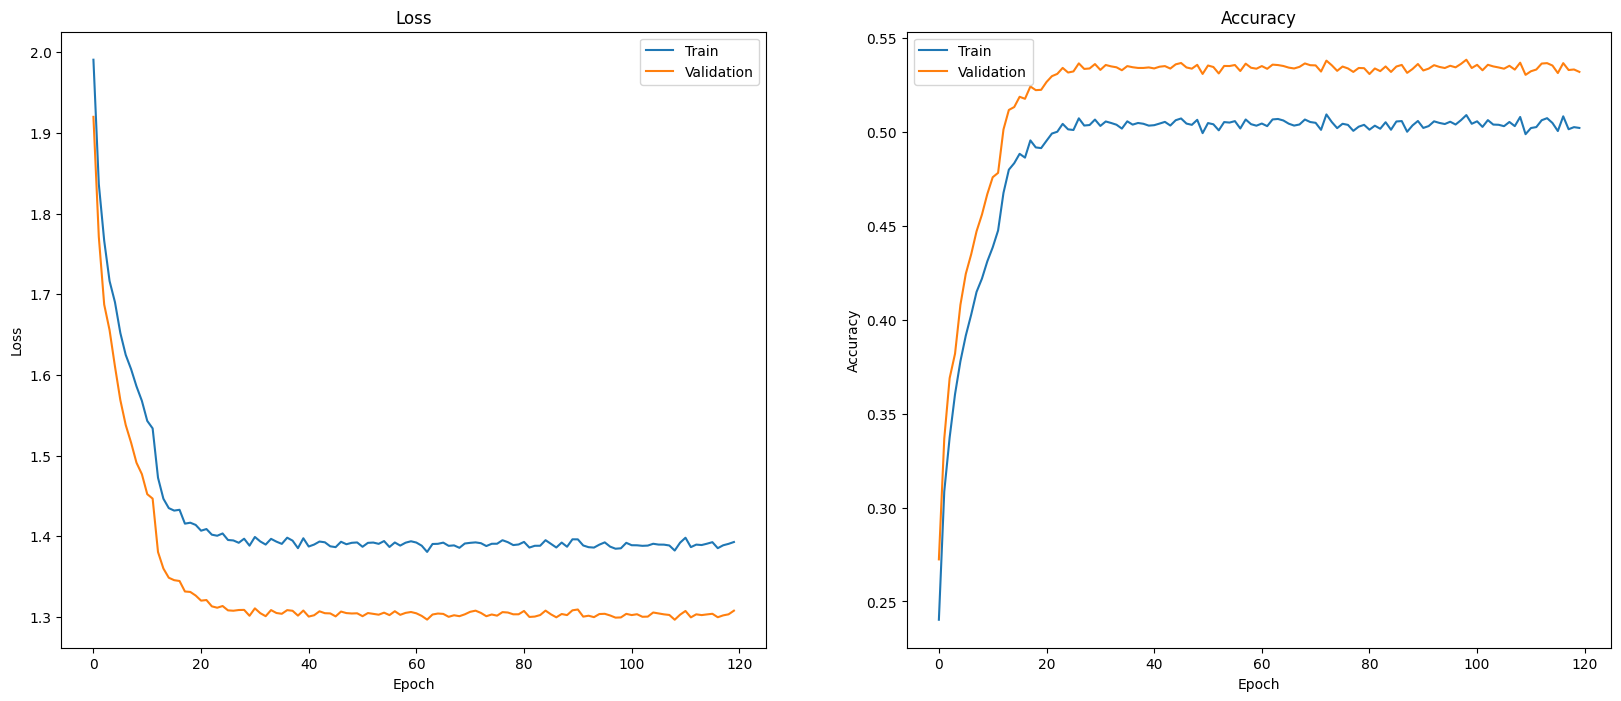

In [112]:
fig, ax = plt.subplots(ncols=2, figsize=(20, 8))

ax1, ax2 = ax.flatten()

ax1.plot(history_net['loss_train'], label='Train')
ax1.plot(history_net['loss_val'], label='Validation')
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.set_title("Loss")
ax1.legend()

ax2.plot(history_net['accuracy_train'], label='Train')
ax2.plot(history_net['accuracy_val'], label='Validation')
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
ax2.set_title("Accuracy")
ax2.legend()

plt.show()

## Проверка модели на тестовых данных

In [71]:
y_true, y_pred = [], []
correct = 0
net.eval()
with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        y_true.append(labels.cpu())
        y_pred.append(predicted.cpu())
    y_true = torch.cat(y_true).numpy()
    y_pred = torch.cat(y_pred).numpy()

print(f'Accuracy on the {dataset_sizes['test']} test images: {100 * correct / dataset_sizes['test']:.2f}%')

Accuracy on the 10000 test images: 37.51%


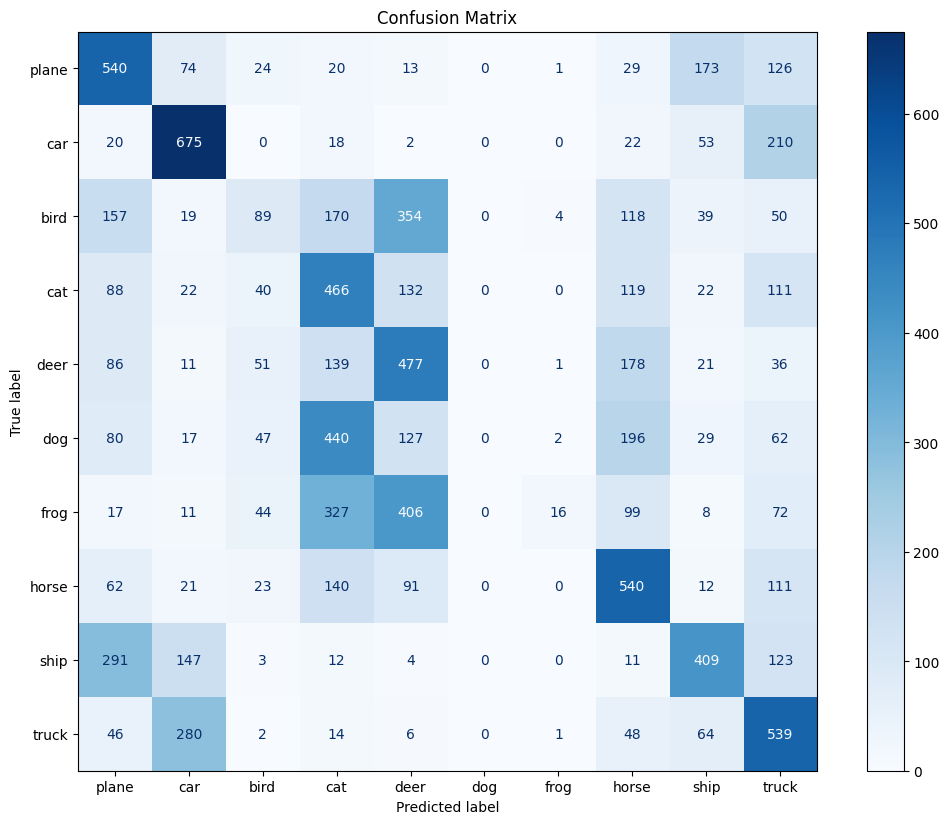

In [72]:
def plot_confusion_matrix(y_true, y_pred, classes=None, cmap="Blues", figsize=(12.8, 9.6)):
    y_t = [classes[label] for label in y_true]
    y_p = [classes[label] for label in y_pred] 
    labels = list(classes.values())

    cm = confusion_matrix(y_t, y_p, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

    fig, ax = plt.subplots(figsize=figsize)
    disp.plot(cmap=cmap, ax=ax)
    ax.set_title(f"Confusion Matrix")
    plt.show()

plot_confusion_matrix(y_true, y_pred, classes=classes)

## Визуализируем неправильно классифицированные изображения

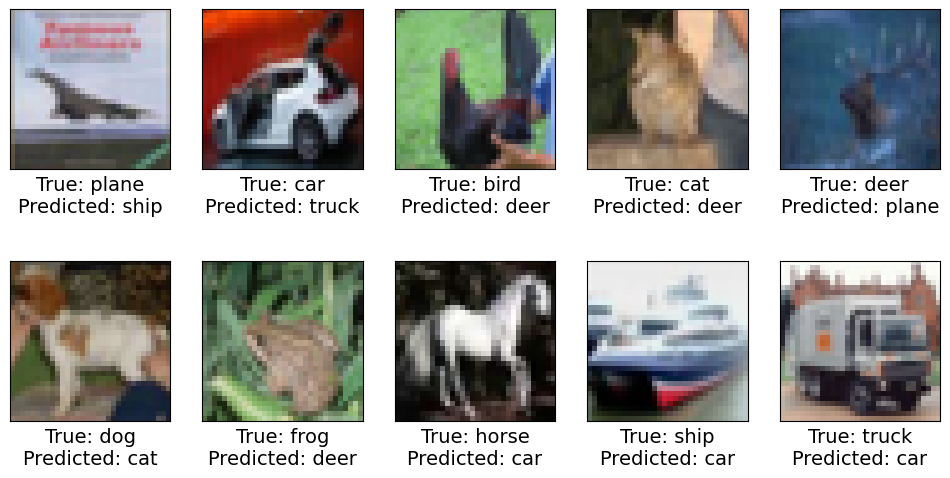

In [73]:
# visualize wrongly classified image for each class
incorrect_mask = y_pred != y_true
incorrect_images = [datasets['test'].data[(y_true == label) & incorrect_mask][0] for label in classes.keys()]
true_results = [y_true[(y_true == label) & incorrect_mask][0] for label in classes.keys()]
pred_results = [y_pred[(y_true == label) & incorrect_mask][0] for label in classes.keys()]

# show images
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
i = 0
for row in axes:
  for axis in row:
    axis.set_xticks([])
    axis.set_yticks([])
    axis.set_xlabel(f"True: {classes[true_results[i]]}\nPredicted: {classes[pred_results[i]]}", fontsize=14)
    axis.imshow(incorrect_images[i])
    i += 1

## Использование предобученной модели

In [85]:
resnet = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
num_features = resnet.fc.in_features
resnet.fc = nn.Linear(num_features, 10)

resnet = resnet.to(device)

In [ ]:
summary(resnet, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]           4,096
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]          16,384
      BatchNorm2d-12            [-1, 256, 8, 8]             512
           Conv2d-13            [-1, 256, 8, 8]          16,384
      BatchNorm2d-14            [-1, 25

In [ ]:
optimizer = optim.Adam(resnet.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, min_lr=0)

In [ ]:
history_resnet = train_model(resnet, dataloaders, criterion, optimizer, scheduler, num_epochs=50)

Epoch 1/50
------------------------------------------------------------------------------------------


Train. Loss: 2.237 | Accuracy: 0.184: 100%|██████████| 1172/1172 [00:27<00:00, 42.36it/s]
Val.   Loss: 2.144 | Accuracy: 0.207: 100%|██████████| 391/391 [00:02<00:00, 130.91it/s]



Epoch 2/50
------------------------------------------------------------------------------------------


Train. Loss: 1.791 | Accuracy: 0.321: 100%|██████████| 1172/1172 [00:28<00:00, 40.56it/s]
Val.   Loss: 1.808 | Accuracy: 0.331: 100%|██████████| 391/391 [00:03<00:00, 113.06it/s]



Epoch 3/50
------------------------------------------------------------------------------------------


Train. Loss: 1.609 | Accuracy: 0.399: 100%|██████████| 1172/1172 [00:27<00:00, 42.77it/s]
Val.   Loss: 1.568 | Accuracy: 0.414: 100%|██████████| 391/391 [00:03<00:00, 125.75it/s]



Epoch 4/50
------------------------------------------------------------------------------------------


Train. Loss: 1.471 | Accuracy: 0.460: 100%|██████████| 1172/1172 [00:27<00:00, 42.97it/s]
Val.   Loss: 1.461 | Accuracy: 0.463: 100%|██████████| 391/391 [00:03<00:00, 127.95it/s]



Epoch 5/50
------------------------------------------------------------------------------------------


Train. Loss: 1.365 | Accuracy: 0.503: 100%|██████████| 1172/1172 [00:27<00:00, 42.28it/s]
Val.   Loss: 1.343 | Accuracy: 0.514: 100%|██████████| 391/391 [00:03<00:00, 125.25it/s]



Epoch 6/50
------------------------------------------------------------------------------------------


Train. Loss: 1.253 | Accuracy: 0.552: 100%|██████████| 1172/1172 [00:27<00:00, 43.33it/s]
Val.   Loss: 1.225 | Accuracy: 0.561: 100%|██████████| 391/391 [00:03<00:00, 125.65it/s]



Epoch 7/50
------------------------------------------------------------------------------------------


Train. Loss: 1.160 | Accuracy: 0.588: 100%|██████████| 1172/1172 [00:27<00:00, 43.36it/s]
Val.   Loss: 1.132 | Accuracy: 0.597: 100%|██████████| 391/391 [00:03<00:00, 119.36it/s]



Epoch 8/50
------------------------------------------------------------------------------------------


Train. Loss: 1.094 | Accuracy: 0.615: 100%|██████████| 1172/1172 [00:27<00:00, 42.53it/s]
Val.   Loss: 1.064 | Accuracy: 0.624: 100%|██████████| 391/391 [00:03<00:00, 123.63it/s]



Epoch 9/50
------------------------------------------------------------------------------------------


Train. Loss: 1.055 | Accuracy: 0.633: 100%|██████████| 1172/1172 [00:28<00:00, 41.68it/s]
Val.   Loss: 1.028 | Accuracy: 0.641: 100%|██████████| 391/391 [00:03<00:00, 125.12it/s]



Epoch 10/50
------------------------------------------------------------------------------------------


Train. Loss: 0.995 | Accuracy: 0.652: 100%|██████████| 1172/1172 [00:26<00:00, 43.43it/s]
Val.   Loss: 0.960 | Accuracy: 0.664: 100%|██████████| 391/391 [00:03<00:00, 123.99it/s]



Epoch 11/50
------------------------------------------------------------------------------------------


Train. Loss: 0.955 | Accuracy: 0.666: 100%|██████████| 1172/1172 [00:26<00:00, 43.51it/s]
Val.   Loss: 0.924 | Accuracy: 0.676: 100%|██████████| 391/391 [00:03<00:00, 125.71it/s]



Epoch 12/50
------------------------------------------------------------------------------------------


Train. Loss: 0.912 | Accuracy: 0.685: 100%|██████████| 1172/1172 [00:26<00:00, 43.92it/s]
Val.   Loss: 0.899 | Accuracy: 0.689: 100%|██████████| 391/391 [00:03<00:00, 125.31it/s]



Epoch 13/50
------------------------------------------------------------------------------------------


Train. Loss: 0.886 | Accuracy: 0.694: 100%|██████████| 1172/1172 [00:26<00:00, 43.74it/s]
Val.   Loss: 0.864 | Accuracy: 0.701: 100%|██████████| 391/391 [00:03<00:00, 125.34it/s]



Epoch 14/50
------------------------------------------------------------------------------------------


Train. Loss: 0.855 | Accuracy: 0.706: 100%|██████████| 1172/1172 [00:31<00:00, 36.79it/s]
Val.   Loss: 0.840 | Accuracy: 0.710: 100%|██████████| 391/391 [00:03<00:00, 123.49it/s]



Epoch 15/50
------------------------------------------------------------------------------------------


Train. Loss: 0.835 | Accuracy: 0.712: 100%|██████████| 1172/1172 [00:26<00:00, 44.00it/s]
Val.   Loss: 0.813 | Accuracy: 0.719: 100%|██████████| 391/391 [00:03<00:00, 123.52it/s]



Epoch 16/50
------------------------------------------------------------------------------------------


Train. Loss: 0.799 | Accuracy: 0.725: 100%|██████████| 1172/1172 [00:27<00:00, 42.74it/s]
Val.   Loss: 0.782 | Accuracy: 0.730: 100%|██████████| 391/391 [00:04<00:00, 90.64it/s] 



Epoch 17/50
------------------------------------------------------------------------------------------


Train. Loss: 0.771 | Accuracy: 0.734: 100%|██████████| 1172/1172 [00:30<00:00, 38.99it/s]
Val.   Loss: 0.772 | Accuracy: 0.735: 100%|██████████| 391/391 [00:03<00:00, 128.43it/s]



Epoch 18/50
------------------------------------------------------------------------------------------


Train. Loss: 0.759 | Accuracy: 0.740: 100%|██████████| 1172/1172 [00:26<00:00, 43.97it/s]
Val.   Loss: 0.752 | Accuracy: 0.743: 100%|██████████| 391/391 [00:03<00:00, 127.52it/s]



Epoch 19/50
------------------------------------------------------------------------------------------


Train. Loss: 0.758 | Accuracy: 0.744: 100%|██████████| 1172/1172 [00:26<00:00, 43.81it/s]
Val.   Loss: 0.834 | Accuracy: 0.740: 100%|██████████| 391/391 [00:03<00:00, 128.40it/s]



Epoch 20/50
------------------------------------------------------------------------------------------


Train. Loss: 0.733 | Accuracy: 0.748: 100%|██████████| 1172/1172 [00:26<00:00, 44.23it/s]
Val.   Loss: 0.731 | Accuracy: 0.750: 100%|██████████| 391/391 [00:03<00:00, 127.49it/s]



Epoch 21/50
------------------------------------------------------------------------------------------


Train. Loss: 0.713 | Accuracy: 0.760: 100%|██████████| 1172/1172 [00:26<00:00, 43.97it/s]
Val.   Loss: 0.703 | Accuracy: 0.763: 100%|██████████| 391/391 [00:03<00:00, 128.05it/s]



Epoch 22/50
------------------------------------------------------------------------------------------


Train. Loss: 0.697 | Accuracy: 0.761: 100%|██████████| 1172/1172 [00:27<00:00, 42.37it/s]
Val.   Loss: 0.700 | Accuracy: 0.761: 100%|██████████| 391/391 [00:03<00:00, 126.59it/s]



Epoch 23/50
------------------------------------------------------------------------------------------


Train. Loss: 0.679 | Accuracy: 0.766: 100%|██████████| 1172/1172 [00:27<00:00, 43.10it/s]
Val.   Loss: 0.681 | Accuracy: 0.769: 100%|██████████| 391/391 [00:03<00:00, 113.08it/s]



Epoch 24/50
------------------------------------------------------------------------------------------


Train. Loss: 0.670 | Accuracy: 0.773: 100%|██████████| 1172/1172 [00:42<00:00, 27.88it/s]
Val.   Loss: 0.678 | Accuracy: 0.771: 100%|██████████| 391/391 [00:03<00:00, 116.74it/s]



Epoch 25/50
------------------------------------------------------------------------------------------


Train. Loss: 0.679 | Accuracy: 0.771: 100%|██████████| 1172/1172 [00:28<00:00, 40.50it/s]
Val.   Loss: 0.671 | Accuracy: 0.775: 100%|██████████| 391/391 [00:03<00:00, 110.80it/s]



Epoch 26/50
------------------------------------------------------------------------------------------


Train. Loss: 0.636 | Accuracy: 0.783: 100%|██████████| 1172/1172 [00:31<00:00, 37.70it/s]
Val.   Loss: 0.632 | Accuracy: 0.783: 100%|██████████| 391/391 [00:03<00:00, 108.82it/s]



Epoch 27/50
------------------------------------------------------------------------------------------


Train. Loss: 0.629 | Accuracy: 0.784: 100%|██████████| 1172/1172 [00:33<00:00, 34.66it/s]
Val.   Loss: 0.633 | Accuracy: 0.784: 100%|██████████| 391/391 [00:03<00:00, 107.49it/s]



Epoch 28/50
------------------------------------------------------------------------------------------


Train. Loss: 0.619 | Accuracy: 0.789: 100%|██████████| 1172/1172 [00:30<00:00, 38.98it/s]
Val.   Loss: 0.640 | Accuracy: 0.785: 100%|██████████| 391/391 [00:03<00:00, 113.13it/s]



Epoch 29/50
------------------------------------------------------------------------------------------


Train. Loss: 0.639 | Accuracy: 0.783: 100%|██████████| 1172/1172 [00:30<00:00, 38.48it/s]
Val.   Loss: 0.656 | Accuracy: 0.781: 100%|██████████| 391/391 [00:03<00:00, 106.07it/s]



Epoch 30/50
------------------------------------------------------------------------------------------


Train. Loss: 0.592 | Accuracy: 0.801: 100%|██████████| 1172/1172 [00:30<00:00, 38.91it/s]
Val.   Loss: 0.597 | Accuracy: 0.800: 100%|██████████| 391/391 [00:03<00:00, 107.26it/s]



Epoch 31/50
------------------------------------------------------------------------------------------


Train. Loss: 0.586 | Accuracy: 0.801: 100%|██████████| 1172/1172 [00:29<00:00, 39.17it/s]
Val.   Loss: 0.600 | Accuracy: 0.797: 100%|██████████| 391/391 [00:03<00:00, 111.81it/s]



Epoch 32/50
------------------------------------------------------------------------------------------


Train. Loss: 0.589 | Accuracy: 0.801: 100%|██████████| 1172/1172 [00:31<00:00, 37.44it/s]
Val.   Loss: 0.631 | Accuracy: 0.798: 100%|██████████| 391/391 [00:03<00:00, 101.44it/s]



Epoch 33/50
------------------------------------------------------------------------------------------


Train. Loss: 0.575 | Accuracy: 0.804: 100%|██████████| 1172/1172 [00:29<00:00, 39.63it/s]
Val.   Loss: 0.585 | Accuracy: 0.802: 100%|██████████| 391/391 [00:03<00:00, 110.50it/s]



Epoch 34/50
------------------------------------------------------------------------------------------


Train. Loss: 0.569 | Accuracy: 0.806: 100%|██████████| 1172/1172 [00:30<00:00, 39.05it/s]
Val.   Loss: 0.571 | Accuracy: 0.807: 100%|██████████| 391/391 [00:03<00:00, 110.70it/s]



Epoch 35/50
------------------------------------------------------------------------------------------


Train. Loss: 0.558 | Accuracy: 0.810: 100%|██████████| 1172/1172 [00:30<00:00, 38.98it/s]
Val.   Loss: 0.619 | Accuracy: 0.805: 100%|██████████| 391/391 [00:03<00:00, 104.53it/s]



Epoch 36/50
------------------------------------------------------------------------------------------


Train. Loss: 0.585 | Accuracy: 0.804: 100%|██████████| 1172/1172 [01:13<00:00, 15.93it/s]
Val.   Loss: 0.589 | Accuracy: 0.802: 100%|██████████| 391/391 [00:11<00:00, 34.26it/s]



Epoch 37/50
------------------------------------------------------------------------------------------


Train. Loss: 0.546 | Accuracy: 0.812: 100%|██████████| 1172/1172 [01:31<00:00, 12.84it/s]
Val.   Loss: 0.558 | Accuracy: 0.810: 100%|██████████| 391/391 [00:03<00:00, 102.00it/s]



Epoch 38/50
------------------------------------------------------------------------------------------


Train. Loss: 0.574 | Accuracy: 0.804: 100%|██████████| 1172/1172 [00:32<00:00, 36.20it/s]
Val.   Loss: 0.573 | Accuracy: 0.805: 100%|██████████| 391/391 [00:03<00:00, 103.52it/s]



Epoch 39/50
------------------------------------------------------------------------------------------


Train. Loss: 0.518 | Accuracy: 0.827: 100%|██████████| 1172/1172 [00:37<00:00, 31.43it/s]
Val.   Loss: 0.533 | Accuracy: 0.822: 100%|██████████| 391/391 [00:03<00:00, 123.29it/s]



Epoch 40/50
------------------------------------------------------------------------------------------


Train. Loss: 0.517 | Accuracy: 0.824: 100%|██████████| 1172/1172 [00:44<00:00, 26.58it/s]
Val.   Loss: 0.527 | Accuracy: 0.822: 100%|██████████| 391/391 [00:03<00:00, 101.82it/s]



Epoch 41/50
------------------------------------------------------------------------------------------


Train. Loss: 0.522 | Accuracy: 0.823: 100%|██████████| 1172/1172 [00:29<00:00, 39.10it/s]
Val.   Loss: 0.527 | Accuracy: 0.822: 100%|██████████| 391/391 [00:04<00:00, 95.73it/s]



Epoch 42/50
------------------------------------------------------------------------------------------


Train. Loss: 0.505 | Accuracy: 0.829: 100%|██████████| 1172/1172 [00:49<00:00, 23.63it/s]
Val.   Loss: 0.526 | Accuracy: 0.824: 100%|██████████| 391/391 [00:03<00:00, 109.63it/s]



Epoch 43/50
------------------------------------------------------------------------------------------


Train. Loss: 0.508 | Accuracy: 0.828: 100%|██████████| 1172/1172 [00:29<00:00, 39.65it/s]
Val.   Loss: 0.533 | Accuracy: 0.823: 100%|██████████| 391/391 [00:03<00:00, 111.36it/s]



Epoch 44/50
------------------------------------------------------------------------------------------


Train. Loss: 0.501 | Accuracy: 0.830: 100%|██████████| 1172/1172 [00:49<00:00, 23.89it/s]
Val.   Loss: 0.511 | Accuracy: 0.828: 100%|██████████| 391/391 [00:09<00:00, 41.55it/s]



Epoch 45/50
------------------------------------------------------------------------------------------


Train. Loss: 0.501 | Accuracy: 0.830: 100%|██████████| 1172/1172 [00:46<00:00, 25.07it/s]
Val.   Loss: 0.600 | Accuracy: 0.826: 100%|██████████| 391/391 [00:03<00:00, 99.73it/s] 



Epoch 46/50
------------------------------------------------------------------------------------------


Train. Loss: 0.488 | Accuracy: 0.833: 100%|██████████| 1172/1172 [00:54<00:00, 21.31it/s]
Val.   Loss: 0.505 | Accuracy: 0.828: 100%|██████████| 391/391 [00:10<00:00, 38.32it/s]



Epoch 47/50
------------------------------------------------------------------------------------------


Train. Loss: 0.479 | Accuracy: 0.836: 100%|██████████| 1172/1172 [01:25<00:00, 13.65it/s]
Val.   Loss: 0.491 | Accuracy: 0.834: 100%|██████████| 391/391 [00:05<00:00, 73.60it/s] 



Epoch 48/50
------------------------------------------------------------------------------------------


Train. Loss: 0.469 | Accuracy: 0.839: 100%|██████████| 1172/1172 [00:30<00:00, 38.07it/s]
Val.   Loss: 0.506 | Accuracy: 0.833: 100%|██████████| 391/391 [00:03<00:00, 108.97it/s]



Epoch 49/50
------------------------------------------------------------------------------------------


Train. Loss: 0.480 | Accuracy: 0.837: 100%|██████████| 1172/1172 [01:10<00:00, 16.66it/s]
Val.   Loss: 0.499 | Accuracy: 0.832: 100%|██████████| 391/391 [00:09<00:00, 39.31it/s]



Epoch 50/50
------------------------------------------------------------------------------------------


Train. Loss: 0.494 | Accuracy: 0.833: 100%|██████████| 1172/1172 [00:48<00:00, 24.34it/s]
Val.   Loss: 0.513 | Accuracy: 0.830: 100%|██████████| 391/391 [00:03<00:00, 108.82it/s]



Training complete in 33m 9s
Best val Accuracy: 0.833920


In [ ]:
torch.save(resnet.state_dict(), os.path.join(PATH, "resnet.pt"))
history_resnet.to_csv(os.path.join(PATH, "history_resnet.csv"), index=False)

In [119]:
resnet.load_state_dict(torch.load(os.path.join(PATH, 'resnet.pt')))
history_resnet = pd.read_csv(os.path.join(PATH, "history_resnet.csv"))

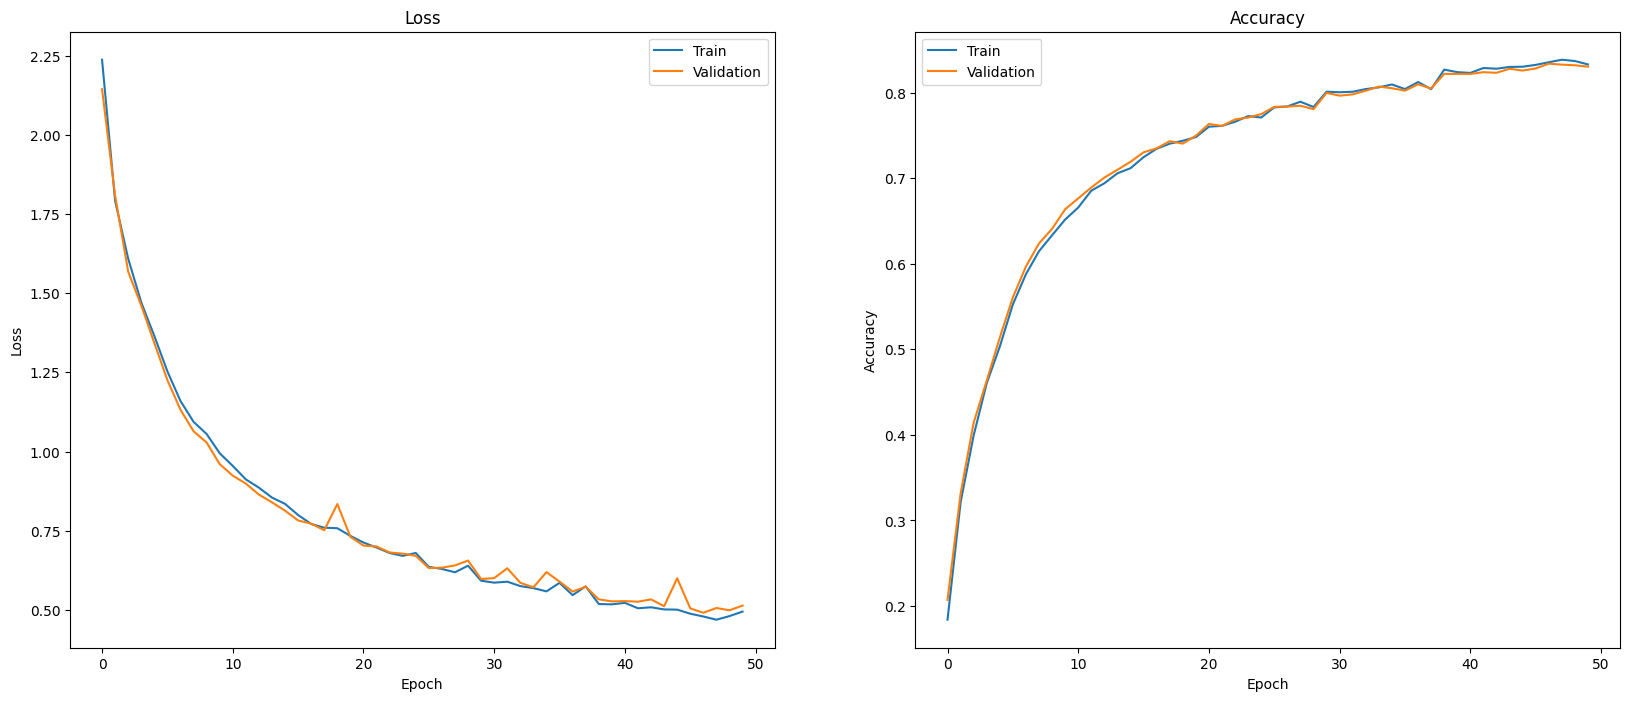

In [120]:
fig, ax = plt.subplots(ncols=2, figsize=(20, 8))

ax1, ax2 = ax.flatten()

ax1.plot(history_resnet['loss_train'], label='Train')
ax1.plot(history_resnet['loss_val'], label='Validation')
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.set_title("Loss")
ax1.legend()

ax2.plot(history_resnet['accuracy_train'], label='Train')
ax2.plot(history_resnet['accuracy_val'], label='Validation')
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
ax2.set_title("Accuracy")
ax2.legend()

plt.show()

In [ ]:
y_true, y_pred = [], []
correct = 0
resnet.eval()
with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = resnet(inputs)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        y_true.append(labels.cpu())
        y_pred.append(predicted.cpu())
    y_true = torch.cat(y_true).numpy()
    y_pred = torch.cat(y_pred).numpy()
    
print(f'Accuracy on the {dataset_sizes['test']} test images: {100 * correct / dataset_sizes['test']:.2f}%')

Accuracy on the 10000 test images: 82.28%


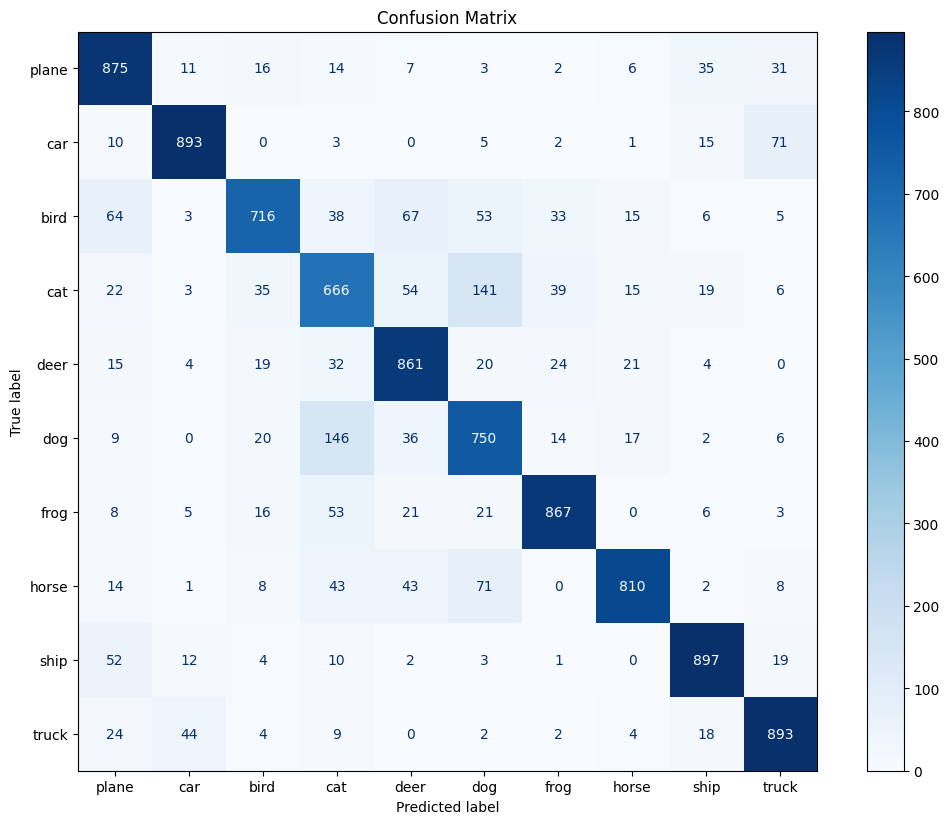

In [39]:
plot_confusion_matrix(y_true, y_pred, classes=classes)

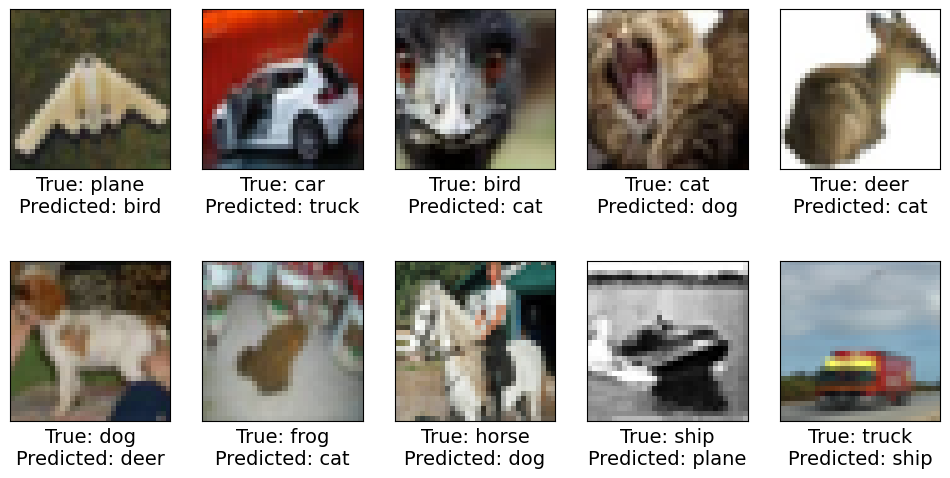

In [84]:
# visualize wrongly classified image for each class
incorrect_mask = y_pred != y_true
incorrect_images = [datasets['test'].data[(y_true == label) & incorrect_mask][0] for label in classes.keys()]
true_results = [y_true[(y_true == label) & incorrect_mask][0] for label in classes.keys()]
pred_results = [y_pred[(y_true == label) & incorrect_mask][0] for label in classes.keys()]

# show images
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
i = 0
for row in axes:
  for axis in row:
    axis.set_xticks([])
    axis.set_yticks([])
    axis.set_xlabel(f"True: {classes[true_results[i]]}\nPredicted: {classes[pred_results[i]]}", fontsize=14)
    axis.imshow(incorrect_images[i])
    i += 1

## Сегментация

[Ссылка на данные](https://www.robots.ox.ac.uk/~vgg/data/pets/)

In [5]:
def merge_trainval_test(filepath):
    path = os.path.join(PATH, filepath, "annotations")
    df = pd.read_csv(os.path.join(path, "trainval.txt"), sep=" ", 
                     names=["Image", "ID", "SPECIES", "BREED ID"])
    df2 = pd.read_csv(os.path.join(path, "test.txt"), sep=" ",
                      names=["Image", "ID", "SPECIES", "BREED ID"])
    frame = [df, df2]
    df = pd.concat(frame)
    df.reset_index(drop=True)
    df.to_csv(os.path.join(path, "data.txt"), index=None, sep=' ')
    print("Merged data is created.")

merge_trainval_test('oxford-iiit-pet')

Merged data is created.


In [4]:
dataset = pd.read_csv(os.path.join(PATH, 'oxford-iiit-pet', 'annotations', "data.txt"), sep=' ')
dataset

,Image,ID,SPECIES,BREED ID
0,Abyssinian_100,1,1,1
1,Abyssinian_101,1,1,1
2,Abyssinian_102,1,1,1
3,Abyssinian_103,1,1,1
4,Abyssinian_104,1,1,1
...,...,...,...,...
7344,yorkshire_terrier_96,37,2,25
7345,yorkshire_terrier_97,37,2,25
7346,yorkshire_terrier_98,37,2,25
7347,yorkshire_terrier_99,37,2,25


In [4]:
image_ids = []
labels = []
with open(os.path.join(PATH, "oxford-iiit-pet", "annotations", "trainval.txt")) as file:
    for line in file:
        image_id, label, *_ = line.strip().split()
        image_ids.append(image_id)
        labels.append(int(label)-1)

classes = [
    " ".join(part.title() for part in raw_cls.split("_"))
    for raw_cls, _ in sorted(
        {(image_id.rsplit("_", 1)[0], label) for image_id, label in zip(image_ids, labels)},
        key=lambda image_id_and_label: image_id_and_label[1],
    )
    ]

idx_to_class = dict(zip(range(len(classes)), classes))

In [6]:
idx_to_class

{0: 'Abyssinian',
 1: 'American Bulldog',
 2: 'American Pit Bull Terrier',
 3: 'Basset Hound',
 4: 'Beagle',
 5: 'Bengal',
 6: 'Birman',
 7: 'Bombay',
 8: 'Boxer',
 9: 'British Shorthair',
 10: 'Chihuahua',
 11: 'Egyptian Mau',
 12: 'English Cocker Spaniel',
 13: 'English Setter',
 14: 'German Shorthaired',
 15: 'Great Pyrenees',
 16: 'Havanese',
 17: 'Japanese Chin',
 18: 'Keeshond',
 19: 'Leonberger',
 20: 'Maine Coon',
 21: 'Miniature Pinscher',
 22: 'Newfoundland',
 23: 'Persian',
 24: 'Pomeranian',
 25: 'Pug',
 26: 'Ragdoll',
 27: 'Russian Blue',
 28: 'Saint Bernard',
 29: 'Samoyed',
 30: 'Scottish Terrier',
 31: 'Shiba Inu',
 32: 'Siamese',
 33: 'Sphynx',
 34: 'Staffordshire Bull Terrier',
 35: 'Wheaten Terrier',
 36: 'Yorkshire Terrier'}

In [7]:
dataset['nID'] = dataset['ID'] - 1

In [8]:
decode_map = idx_to_class
def decode_label(label):
    return decode_map[int(label)]

dataset["class"] = dataset["nID"].apply(lambda x: decode_label(x))

In [9]:
dataset

,Image,ID,SPECIES,BREED ID,nID,class
0,Abyssinian_100,1,1,1,0,Abyssinian
1,Abyssinian_101,1,1,1,0,Abyssinian
2,Abyssinian_102,1,1,1,0,Abyssinian
3,Abyssinian_103,1,1,1,0,Abyssinian
4,Abyssinian_104,1,1,1,0,Abyssinian
...,...,...,...,...,...,...
7344,yorkshire_terrier_96,37,2,25,36,Yorkshire Terrier
7345,yorkshire_terrier_97,37,2,25,36,Yorkshire Terrier
7346,yorkshire_terrier_98,37,2,25,36,Yorkshire Terrier
7347,yorkshire_terrier_99,37,2,25,36,Yorkshire Terrier


In [10]:
dataset['class'].value_counts()

class
American Bulldog              200
Basset Hound                  200
American Pit Bull Terrier     200
Beagle                        200
Bengal                        200
Yorkshire Terrier             200
Birman                        200
Chihuahua                     200
British Shorthair             200
Havanese                      200
Great Pyrenees                200
German Shorthaired            200
English Setter                200
Japanese Chin                 200
Leonberger                    200
Maine Coon                    200
Russian Blue                  200
Pug                           200
Pomeranian                    200
Persian                       200
Miniature Pinscher            200
Saint Bernard                 200
Shiba Inu                     200
Wheaten Terrier               200
Sphynx                        200
Samoyed                       200
Ragdoll                       200
Siamese                       199
Boxer                         199
Keeshond

In [11]:
y = dataset["class"]
x = dataset["Image"]

trainval, x_test, y_trainval, y_test = train_test_split(
    x, y, stratify=y, test_size=0.2, random_state=42
)

x_train, x_val, y_train, y_val = train_test_split(
    trainval, y_trainval, stratify=y_trainval, test_size=0.3, random_state=42
)

In [12]:
df_train = pd.DataFrame(y_train)
print("About data:")
print(df_train.describe())

print("\n****** Class Distribution ******")
print(df_train['class'].value_counts())

About data:
                  class
count              4115
unique               37
top     Wheaten Terrier
freq                112

****** Class Distribution ******
class
Wheaten Terrier               112
Beagle                        112
Birman                        112
Pug                           112
Persian                       112
American Pit Bull Terrier     112
Russian Blue                  112
Yorkshire Terrier             112
Leonberger                    112
Sphynx                        112
Pomeranian                    112
Japanese Chin                 112
American Bulldog              112
Bengal                        112
Shiba Inu                     112
Samoyed                       112
Basset Hound                  112
Saint Bernard                 112
Miniature Pinscher            112
Chihuahua                     112
English Setter                112
German Shorthaired            112
Great Pyrenees                112
Havanese                      112
Maine Coon  

In [13]:
df_val = pd.DataFrame(y_val)
print("About data:")
print(df_val.describe())

print("\n****** Class Distribution ******")
print(df_val['class'].value_counts())

About data:
             class
count         1764
unique          37
top     Abyssinian
freq            48

****** Class Distribution ******
class
Abyssinian                    48
German Shorthaired            48
American Bulldog              48
Wheaten Terrier               48
Sphynx                        48
Scottish Terrier              48
Great Pyrenees                48
Basset Hound                  48
Saint Bernard                 48
Maine Coon                    48
American Pit Bull Terrier     48
Shiba Inu                     48
Beagle                        48
Ragdoll                       48
Leonberger                    48
Siamese                       48
Pug                           48
Yorkshire Terrier             48
Pomeranian                    48
Birman                        48
English Setter                48
British Shorthair             48
Japanese Chin                 48
Miniature Pinscher            48
Persian                       48
Boxer                       

In [14]:
df_test = pd.DataFrame(y_test)
print("About data:")
print(df_test.describe())

print("\n****** Class Distribution ******")
print(df_test['class'].value_counts())

About data:
         class
count     1470
unique      37
top     Sphynx
freq        40

****** Class Distribution ******
class
Sphynx                        40
Japanese Chin                 40
German Shorthaired            40
Beagle                        40
Miniature Pinscher            40
Yorkshire Terrier             40
British Shorthair             40
Saint Bernard                 40
Samoyed                       40
Birman                        40
Pomeranian                    40
Ragdoll                       40
Boxer                         40
American Bulldog              40
Pug                           40
Russian Blue                  40
English Setter                40
Great Pyrenees                40
Havanese                      40
Maine Coon                    40
Bengal                        40
Siamese                       40
Shiba Inu                     40
Keeshond                      40
Leonberger                    40
Scottish Terrier              40
Persian        

In [15]:
root_directory = os.path.join(PATH, "oxford-iiit-pet")
images_directory = os.path.join(root_directory, "images")
masks_directory = os.path.join(root_directory, "annotations", "trimaps")

train_images_filenames = x_train.reset_index(drop=True)
val_images_filenames = x_val.reset_index(drop=True)
test_images_filenames = x_test.reset_index(drop=True)

In [16]:
def preprocess_mask(mask):
    mask = np.float32(mask) / 255
    mask[mask == 2.0] = 0.0
    mask[(mask == 1.0) | (mask == 3.0)] = 1.0
    return mask

In [52]:
def display_image_grid(images_filenames, images_directory, masks_directory, predicted_masks=None):
    cols = 3 if predicted_masks is not None  else 2
    rows = len(images_filenames)
    fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(10, 24))
    for i, image_filename in enumerate(images_filenames):
        image = Image.open(os.path.join(images_directory, f'{image_filename}.jpg')).convert('RGB')

        mask = Image.open(os.path.join(masks_directory, f'{image_filename}.png'))
        mask = preprocess_mask(mask)
        ax[i, 0].imshow(image)
        ax[i, 1].imshow(mask, interpolation="nearest")

        ax[i, 0].set_title("Image")
        ax[i, 1].set_title("Ground truth mask")

        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()

        if predicted_masks is not None:
            predicted_mask = predicted_masks[i]
            ax[i, 2].imshow(predicted_mask, interpolation="nearest")
            ax[i, 2].set_title("Predicted mask")
            ax[i, 2].set_axis_off()
    plt.tight_layout()
    plt.show()

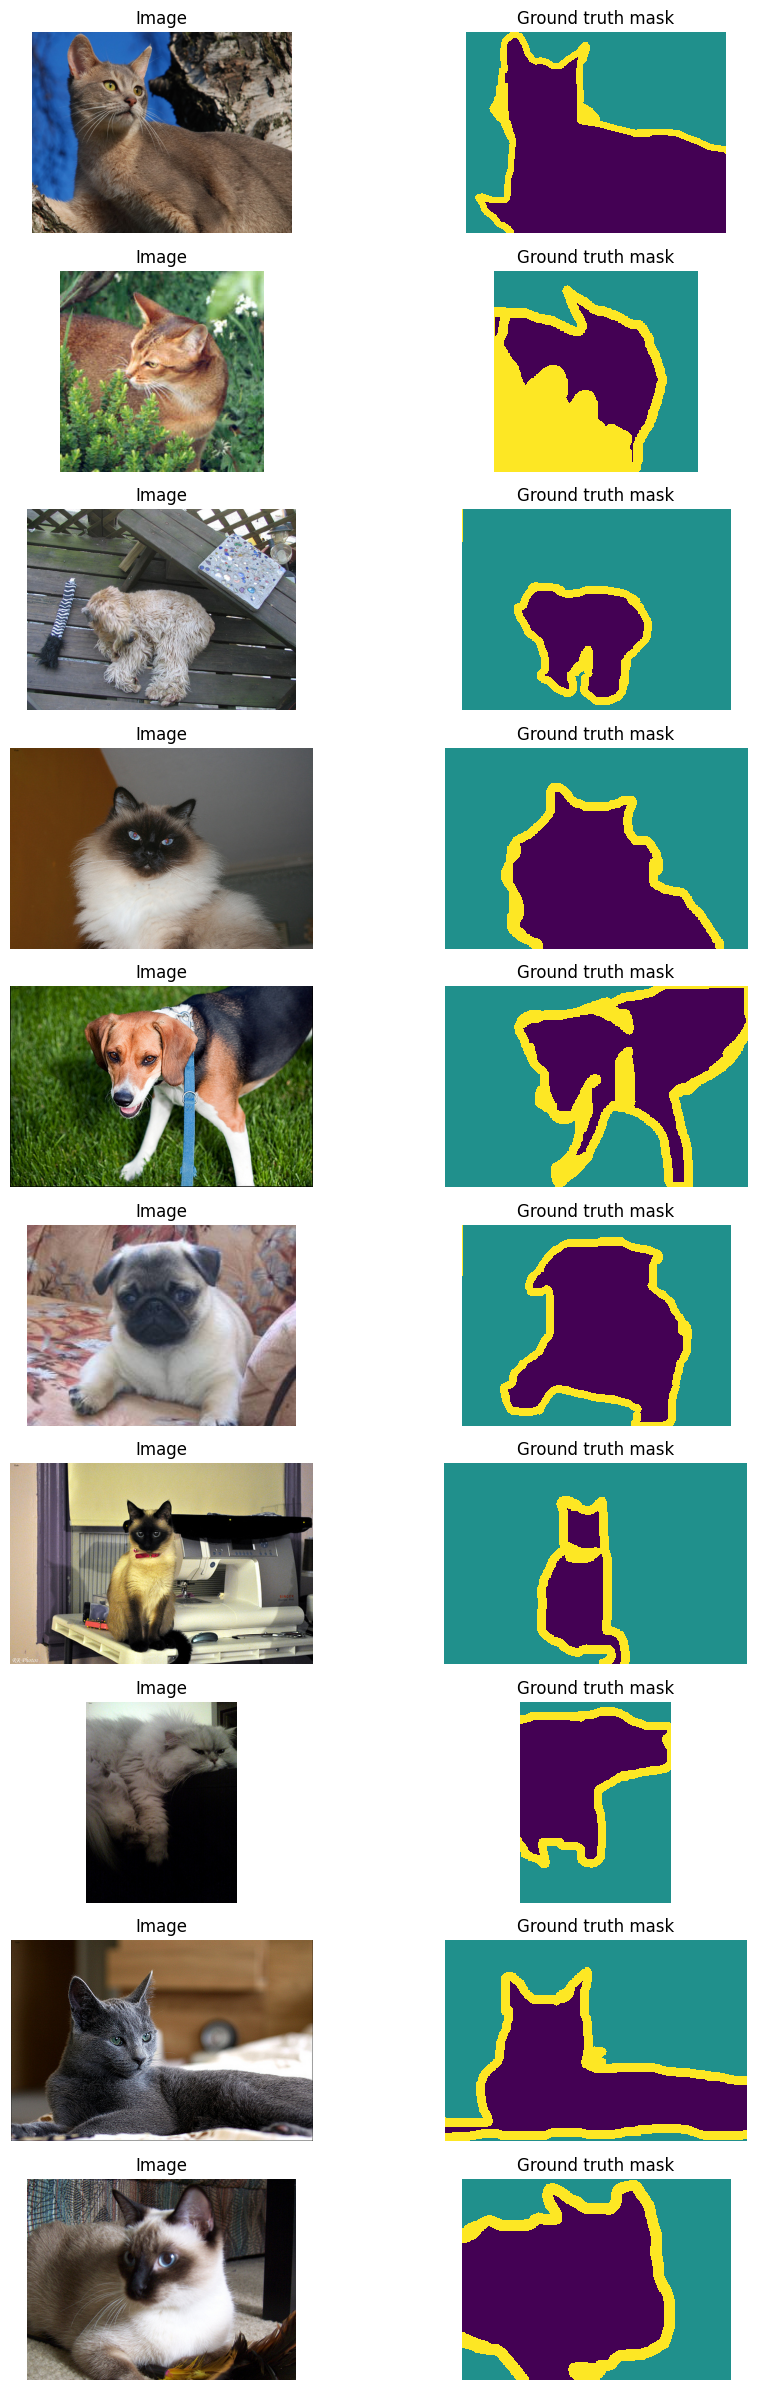

In [19]:
display_image_grid(train_images_filenames[:10], images_directory, masks_directory)

In [18]:
class OxfordPetDataset(Dataset):
    def __init__(
        self,
        images_filenames,
        images_directory,
        masks_directory,
        transform=None,
        transform_mask=None,
    ):
        self.images_filenames = images_filenames
        self.images_directory = images_directory
        self.masks_directory = masks_directory
        self.transform = transform
        self.transform_mask = transform_mask

    def __len__(self):
        return len(self.images_filenames)

    def __getitem__(self, idx):
        image_filename = self.images_filenames.loc[idx] + ".jpg"
        image = Image.open(
            os.path.join(self.images_directory, image_filename)
        ).convert("RGB")
        mask = Image.open(
            os.path.join(
                self.masks_directory, image_filename.replace(".jpg", ".png")
            )
        )
        if self.transform is not None:
            transformed = self.transform(image)
            transformed_m = self.transform_mask(mask)
            image = transformed
            mask = transformed_m
        return image, mask

In [19]:
train_transform = v2.Compose(
    [
        v2.Resize((256, 256)),
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)
target_transform = v2.Compose(
    [
        v2.PILToTensor(),
        v2.Resize((256, 256)),
        v2.Lambda(lambda x: (x - 1).squeeze().type(torch.LongTensor)),
    ]
)

In [20]:
train_dataset = OxfordPetDataset(
    train_images_filenames,
    images_directory,
    masks_directory,
    transform=train_transform,
    transform_mask=target_transform,
)
val_dataset = OxfordPetDataset(
    val_images_filenames,
    images_directory,
    masks_directory,
    transform=train_transform,
    transform_mask=target_transform,
)
test_dataset = OxfordPetDataset(
    test_images_filenames,
    images_directory,
    masks_directory,
    transform=train_transform,
    transform_mask=target_transform
)

In [26]:
class DecoderBlock(nn.Module):
    def __init__(self, in_channels, n_filters):
        super().__init__()

        # B, C, H, W -> B, C/4, H, W
        self.conv1 = nn.Conv2d(in_channels, in_channels // 4, 1)
        self.norm1 = nn.BatchNorm2d(in_channels // 4)
        self.relu1 = nn.ReLU()

        # B, C/4, H, W -> B, C/4, H, W
        self.deconv2 = nn.ConvTranspose2d(
            in_channels // 4,
            in_channels // 4,
            3,
            stride=2,
            padding=1,
            output_padding=1,
        )
        self.norm2 = nn.BatchNorm2d(in_channels // 4)
        self.relu2 = nn.ReLU()

        # B, C/4, H, W -> B, C, H, W
        self.conv3 = nn.Conv2d(in_channels // 4, n_filters, 1)
        self.norm3 = nn.BatchNorm2d(n_filters)
        self.relu3 = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.norm1(x)
        x = self.relu1(x)
        x = self.deconv2(x)
        x = self.norm2(x)
        x = self.relu2(x)
        x = self.conv3(x)
        x = self.norm3(x)
        x = self.relu3(x)
        return x


class LinkNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        filters = [64, 128, 256, 512]

        res = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

        self.firstconv = res.conv1
        self.firstbn = res.bn1
        self.firstrelu = res.relu
        self.firstmaxpool = res.maxpool
        self.encoder1 = res.layer1
        self.encoder2 = res.layer2
        self.encoder3 = res.layer3
        self.encoder4 = res.layer4

        # Decoder
        self.decoder4 = DecoderBlock(filters[3], filters[2])
        self.decoder3 = DecoderBlock(filters[2], filters[1])
        self.decoder2 = DecoderBlock(filters[1], filters[0])
        self.decoder1 = DecoderBlock(filters[0], filters[0])

        # Final Classifier
        self.finaldeconv1 = nn.ConvTranspose2d(filters[0], 32, 3, stride=2)
        self.finalrelu1 = nn.ReLU()
        self.finalconv2 = nn.Conv2d(32, 32, 3)
        self.finalrelu2 = nn.ReLU()
        self.finalconv3 = nn.Conv2d(32, num_classes, 2, padding=1)

    def forward(self, x):
        # Encoder
        x = self.firstconv(x)
        x = self.firstbn(x)
        x = self.firstrelu(x)
        x = self.firstmaxpool(x)
        e1 = self.encoder1(x)
        e2 = self.encoder2(e1)
        e3 = self.encoder3(e2)
        e4 = self.encoder4(e3)

        # Decoder with Skip Connections
        d4 = self.decoder4(e4) + e3
        d3 = self.decoder3(d4) + e2
        d2 = self.decoder2(d3) + e1
        d1 = self.decoder1(d2)

        # Final Classification
        x = self.finaldeconv1(d1)
        x = self.finalrelu1(x)
        x = self.finalconv2(x)
        x = self.finalrelu2(x)
        x = self.finalconv3(x)
        return x

In [27]:
linknet = LinkNet(3).to(device)
summary(linknet, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
       BasicBlock-11           [-1, 64, 64, 64]               0
           Conv2d-12           [-1, 64, 64, 64]          36,864
      BatchNorm2d-13           [-1, 64, 64, 64]             128
             ReLU-14           [-1, 64,

In [54]:
params = {
    "lr": 0.001,
    "batch_size": 32,
    "num_workers": 0,
    "epochs": 25,
}

train_loader = DataLoader(
    train_dataset,
    batch_size=params["batch_size"],
    shuffle=True,
    num_workers=params["num_workers"],
    pin_memory=True,

)
val_loader = DataLoader(
    val_dataset,
    batch_size=params["batch_size"],
    shuffle=True,
    num_workers=params["num_workers"],
    pin_memory=True,
)
test_loader = DataLoader(
    test_dataset,
    batch_size=params["batch_size"],
    num_workers=params["num_workers"],
    pin_memory=True,
)

dataloaders = {'train': train_loader, 'val': val_loader, 'test': test_loader}

In [97]:
optimizer = torch.optim.AdamW(linknet.parameters(), lr=params["lr"])
criterion = nn.CrossEntropyLoss()

history_linknet = train_model(linknet, criterion, optimizer, num_epochs=params['epochs'])

Epoch 1/25
------------------------------------------------------------------------------------------


Train. Loss: 0.459 | Accuracy: 0.794: 100%|██████████| 129/129 [02:36<00:00,  1.21s/it]
Val.   Loss: 0.423 | Accuracy: 0.820: 100%|██████████| 56/56 [01:06<00:00,  1.18s/it]



Epoch 2/25
------------------------------------------------------------------------------------------


Train. Loss: 0.278 | Accuracy: 0.898: 100%|██████████| 129/129 [00:39<00:00,  3.27it/s]
Val.   Loss: 0.276 | Accuracy: 0.899: 100%|██████████| 56/56 [00:13<00:00,  4.18it/s]



Epoch 3/25
------------------------------------------------------------------------------------------


Train. Loss: 0.241 | Accuracy: 0.911: 100%|██████████| 129/129 [00:39<00:00,  3.28it/s]
Val.   Loss: 0.244 | Accuracy: 0.910: 100%|██████████| 56/56 [00:13<00:00,  4.20it/s]



Epoch 4/25
------------------------------------------------------------------------------------------


Train. Loss: 0.207 | Accuracy: 0.922: 100%|██████████| 129/129 [00:39<00:00,  3.29it/s]
Val.   Loss: 0.219 | Accuracy: 0.918: 100%|██████████| 56/56 [00:13<00:00,  4.14it/s]



Epoch 5/25
------------------------------------------------------------------------------------------


Train. Loss: 0.196 | Accuracy: 0.926: 100%|██████████| 129/129 [00:39<00:00,  3.28it/s]
Val.   Loss: 0.214 | Accuracy: 0.919: 100%|██████████| 56/56 [00:13<00:00,  4.15it/s]



Epoch 6/25
------------------------------------------------------------------------------------------


Train. Loss: 0.199 | Accuracy: 0.925: 100%|██████████| 129/129 [00:39<00:00,  3.28it/s]
Val.   Loss: 0.213 | Accuracy: 0.920: 100%|██████████| 56/56 [00:13<00:00,  4.22it/s]



Epoch 7/25
------------------------------------------------------------------------------------------


Train. Loss: 0.174 | Accuracy: 0.933: 100%|██████████| 129/129 [00:39<00:00,  3.29it/s]
Val.   Loss: 0.189 | Accuracy: 0.929: 100%|██████████| 56/56 [00:13<00:00,  4.22it/s]



Epoch 8/25
------------------------------------------------------------------------------------------


Train. Loss: 0.158 | Accuracy: 0.939: 100%|██████████| 129/129 [00:39<00:00,  3.29it/s]
Val.   Loss: 0.177 | Accuracy: 0.934: 100%|██████████| 56/56 [00:13<00:00,  4.22it/s]



Epoch 9/25
------------------------------------------------------------------------------------------


Train. Loss: 0.182 | Accuracy: 0.931: 100%|██████████| 129/129 [00:39<00:00,  3.30it/s]
Val.   Loss: 0.201 | Accuracy: 0.925: 100%|██████████| 56/56 [00:13<00:00,  4.18it/s]



Epoch 10/25
------------------------------------------------------------------------------------------


Train. Loss: 0.169 | Accuracy: 0.935: 100%|██████████| 129/129 [00:39<00:00,  3.30it/s]
Val.   Loss: 0.190 | Accuracy: 0.928: 100%|██████████| 56/56 [00:13<00:00,  4.15it/s]



Epoch 11/25
------------------------------------------------------------------------------------------


Train. Loss: 0.150 | Accuracy: 0.942: 100%|██████████| 129/129 [00:39<00:00,  3.31it/s]
Val.   Loss: 0.174 | Accuracy: 0.935: 100%|██████████| 56/56 [00:13<00:00,  4.19it/s]



Epoch 12/25
------------------------------------------------------------------------------------------


Train. Loss: 0.138 | Accuracy: 0.946: 100%|██████████| 129/129 [00:39<00:00,  3.30it/s]
Val.   Loss: 0.163 | Accuracy: 0.939: 100%|██████████| 56/56 [00:13<00:00,  4.19it/s]



Epoch 13/25
------------------------------------------------------------------------------------------


Train. Loss: 0.126 | Accuracy: 0.950: 100%|██████████| 129/129 [00:39<00:00,  3.28it/s]
Val.   Loss: 0.160 | Accuracy: 0.942: 100%|██████████| 56/56 [00:13<00:00,  4.19it/s]



Epoch 14/25
------------------------------------------------------------------------------------------


Train. Loss: 0.121 | Accuracy: 0.953: 100%|██████████| 129/129 [00:39<00:00,  3.30it/s]
Val.   Loss: 0.157 | Accuracy: 0.944: 100%|██████████| 56/56 [00:13<00:00,  4.20it/s]



Epoch 15/25
------------------------------------------------------------------------------------------


Train. Loss: 0.114 | Accuracy: 0.955: 100%|██████████| 129/129 [00:39<00:00,  3.30it/s]
Val.   Loss: 0.153 | Accuracy: 0.946: 100%|██████████| 56/56 [00:13<00:00,  4.18it/s]



Epoch 16/25
------------------------------------------------------------------------------------------


Train. Loss: 0.110 | Accuracy: 0.957: 100%|██████████| 129/129 [00:38<00:00,  3.31it/s]
Val.   Loss: 0.153 | Accuracy: 0.946: 100%|██████████| 56/56 [00:13<00:00,  4.21it/s]



Epoch 17/25
------------------------------------------------------------------------------------------


Train. Loss: 0.106 | Accuracy: 0.959: 100%|██████████| 129/129 [00:39<00:00,  3.31it/s]
Val.   Loss: 0.153 | Accuracy: 0.947: 100%|██████████| 56/56 [00:13<00:00,  4.20it/s]



Epoch 18/25
------------------------------------------------------------------------------------------


Train. Loss: 0.127 | Accuracy: 0.951: 100%|██████████| 129/129 [00:41<00:00,  3.12it/s]
Val.   Loss: 0.195 | Accuracy: 0.929: 100%|██████████| 56/56 [00:13<00:00,  4.11it/s]



Epoch 19/25
------------------------------------------------------------------------------------------


Train. Loss: 0.196 | Accuracy: 0.926: 100%|██████████| 129/129 [00:39<00:00,  3.25it/s]
Val.   Loss: 0.216 | Accuracy: 0.921: 100%|██████████| 56/56 [00:13<00:00,  4.15it/s]



Epoch 20/25
------------------------------------------------------------------------------------------


Train. Loss: 0.159 | Accuracy: 0.938: 100%|██████████| 129/129 [00:39<00:00,  3.28it/s]
Val.   Loss: 0.182 | Accuracy: 0.932: 100%|██████████| 56/56 [00:13<00:00,  4.12it/s]



Epoch 21/25
------------------------------------------------------------------------------------------


Train. Loss: 0.130 | Accuracy: 0.949: 100%|██████████| 129/129 [00:39<00:00,  3.28it/s]
Val.   Loss: 0.161 | Accuracy: 0.941: 100%|██████████| 56/56 [00:13<00:00,  4.16it/s]



Epoch 22/25
------------------------------------------------------------------------------------------


Train. Loss: 0.111 | Accuracy: 0.956: 100%|██████████| 129/129 [00:39<00:00,  3.29it/s]
Val.   Loss: 0.153 | Accuracy: 0.946: 100%|██████████| 56/56 [00:13<00:00,  4.18it/s]



Epoch 23/25
------------------------------------------------------------------------------------------


Train. Loss: 0.103 | Accuracy: 0.960: 100%|██████████| 129/129 [00:39<00:00,  3.28it/s]
Val.   Loss: 0.150 | Accuracy: 0.949: 100%|██████████| 56/56 [00:13<00:00,  4.16it/s]



Epoch 24/25
------------------------------------------------------------------------------------------


Train. Loss: 0.096 | Accuracy: 0.962: 100%|██████████| 129/129 [00:39<00:00,  3.29it/s]
Val.   Loss: 0.149 | Accuracy: 0.950: 100%|██████████| 56/56 [00:13<00:00,  4.18it/s]



Epoch 25/25
------------------------------------------------------------------------------------------


Train. Loss: 0.091 | Accuracy: 0.965: 100%|██████████| 129/129 [00:39<00:00,  3.30it/s]
Val.   Loss: 0.148 | Accuracy: 0.952: 100%|██████████| 56/56 [00:13<00:00,  4.20it/s]


Training complete in 24m 49s
Best val Accuracy: 0.951531


In [ ]:
torch.save(linknet.state_dict(), os.path.join(PATH, 'linknet.pt'))
history_linknet.to_csv(os.path.join(PATH, 'history_linknet.csv'), index=False)

In [29]:
linknet.load_state_dict(torch.load(os.path.join(PATH, 'linknet.pt')))
history_linknet = pd.read_csv(os.path.join(PATH, "history_linknet.csv"))

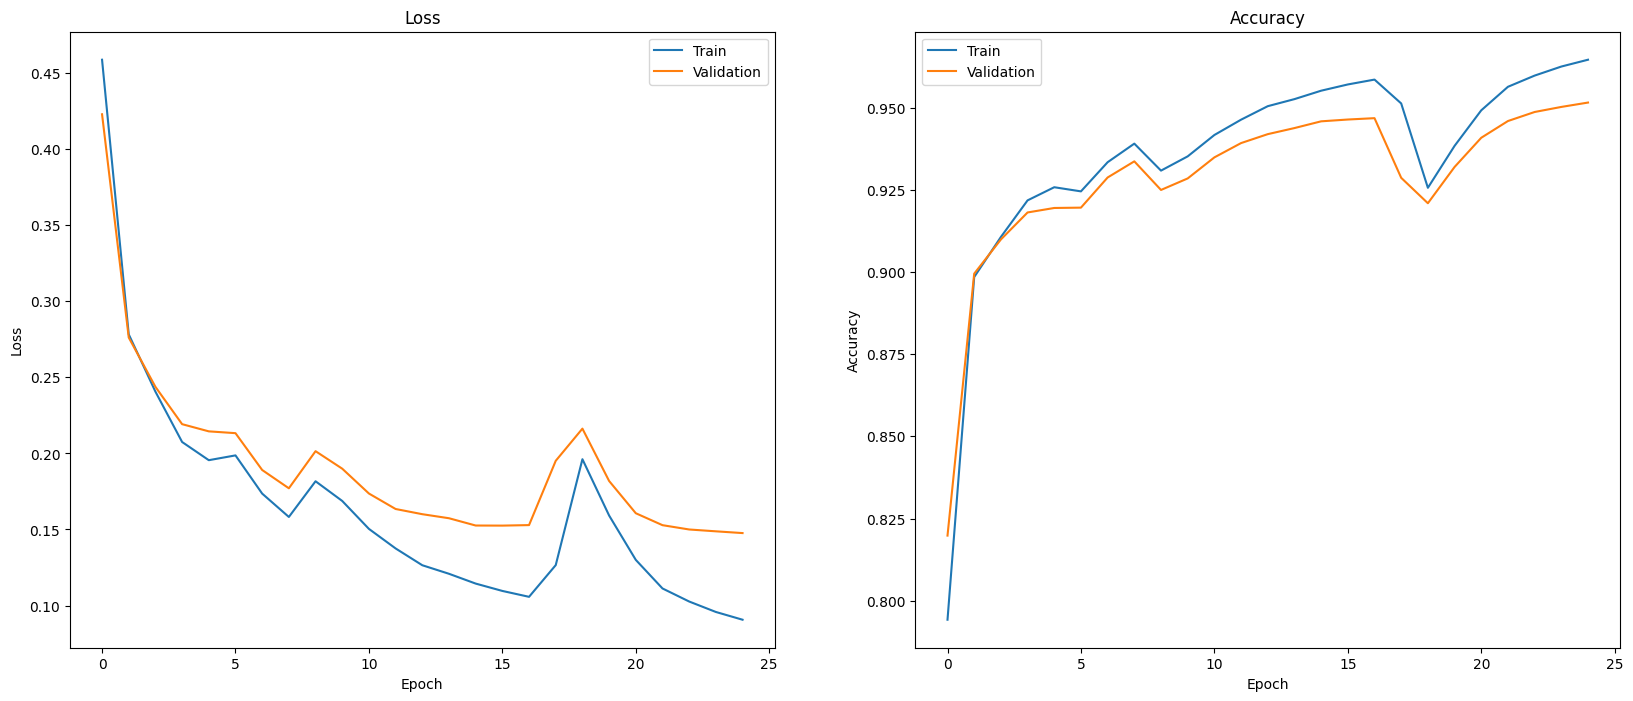

In [30]:
fig, ax = plt.subplots(ncols=2, figsize=(20, 8))

ax1, ax2 = ax.flatten()

ax1.plot(history_linknet['loss_train'], label='Train')
ax1.plot(history_linknet['loss_val'], label='Validation')
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.set_title("Loss")
ax1.legend()

ax2.plot(history_linknet['accuracy_train'], label='Train')
ax2.plot(history_linknet['accuracy_val'], label='Validation')
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
ax2.set_title("Accuracy")
ax2.legend()

plt.show()

In [56]:
predicted_masks = []
correct = 0
linknet.eval()
with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = linknet(inputs)
        _, pred_mask = torch.max(outputs, 1)
        correct += (pred_mask == labels).sum().item()
        predicted_masks.append(pred_mask.cpu())
    predicted_masks = torch.cat(predicted_masks).numpy()

print(f'Accuracy on the {len(dataloaders['test'].dataset)} test images: {100 * correct / len(dataloaders['test'].dataset) / 256 / 256:.2f}%')

Accuracy on the 1470 test images: 91.82%


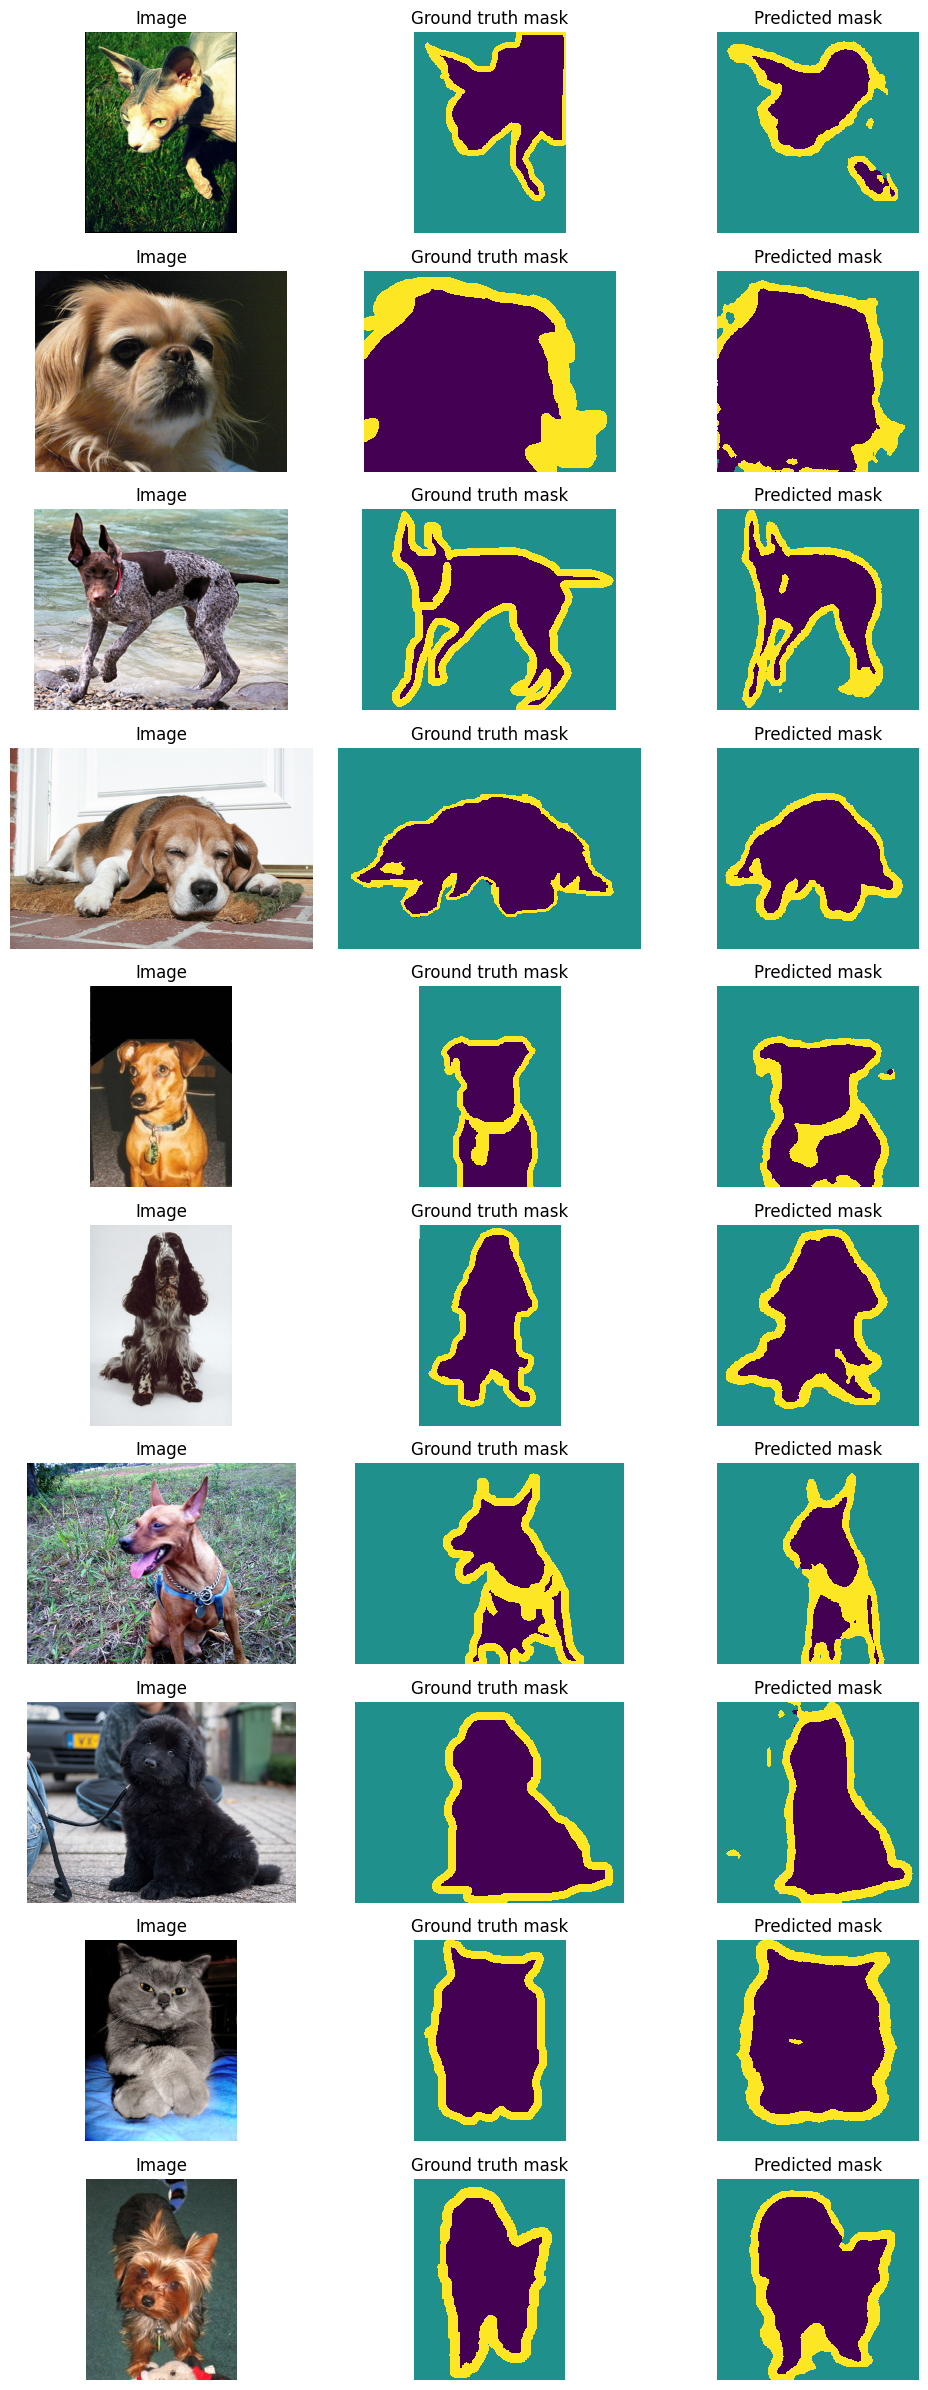

In [57]:
display_image_grid(test_images_filenames[:10], images_directory, masks_directory, predicted_masks=predicted_masks)